# Run me before Section 7-!

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

##1.Data preparation


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# %cd /content/drive/My Drive/hu_joint_nlu_multiturn/M2M

%cd /content/drive/My Drive/tri-model/M2M

/content/drive/My Drive/tri-model/M2M


In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
import glob
import os
from keras.utils import plot_model

files = glob.glob('data/sim-*/train.json')
train_data = []

if __name__ == '__main__':
  for fn in files:
    with open(fn, 'rb') as f:
        train_data.append(pd.read_json(fn))

train_data = pd.concat(train_data,ignore_index=True)


files = glob.glob('data/sim-*/dev.json')
dev_data = []

if __name__ == '__main__':
  for fn in files:
    with open(fn, 'rb') as f:
        dev_data.append(pd.read_json(fn))

dev_data = pd.concat(dev_data,ignore_index=True)


files = glob.glob('data/sim-*/test.json')
test_data = []

if __name__ == '__main__':
  for fn in files:
    with open(fn, 'rb') as f:
        test_data.append(pd.read_json(fn))

test_data = pd.concat(test_data,ignore_index=True)

In [5]:
def get_slot_intent_domain(dataset):
  tokens = []
  domains = []
  slots = []
  slot_values = []
  turns = []
  intents = []
  dataset_seq = []
  dataset_slot = []
  dataset_intent = []
  dataset_domain = []
  slot_loc = []
  max_turn_len = 0

  for i in range(len(dataset)):
    tokens += [y['user_utterance']['tokens'] for y in dataset.iloc[i]['turns'] if 'user_utterance' in y] + \
    [y['system_utterance']['tokens'] for y in dataset.iloc[i]['turns'] if 'system_utterance' in y]
    turns.append(len([y for y in dataset.iloc[i]['turns'] if 'user_utterance' in y]) +
                len([y for y in dataset.iloc[i]['turns'] if 'system_utterance' in y]))
    max_turn_len = max([len(y['user_utterance']['tokens']) for y in dataset.iloc[i]['turns'] if 'user_utterance' in y]
                      +[len(y['system_utterance']['tokens']) for y in dataset.iloc[i]['turns'] if 'system_utterance' in y] \
                      + [max_turn_len])
    slots.append([[x['slot'] for x in y['dialogue_state']] for y in dataset.iloc[i]['turns']])
    slot_values.append([[x['value'] for x in y['dialogue_state']] for y in dataset.iloc[i]['turns']])
    domains += [y['user_intents'] for y in dataset.iloc[i]['turns'] if 'user_intents' in y]
    intents.append(list(set([y['user_acts'][0]['type'] for y in dataset.iloc[i]['turns'] if len(y['user_acts']) > 0])))

    for utterance in dataset['turns'][i]:
      if 'system_utterance' in utterance:
        dataset_seq.append(utterance['system_utterance']['tokens'])
        slot_loc.append(utterance['system_utterance']['slots'])
        slot_value = []
        for dic in utterance['system_acts']:
          if 'value' in dic:
            slot_value.append({dic['slot']:dic['value']})
          else:
            slot_value.append({})
        dataset_intent.append(utterance['system_acts'][0]['type'])
        dataset_slot.append(slot_value)
        dataset_domain.append(domains[-1])
      if len(utterance['user_acts']):
        dataset_seq.append(utterance['user_utterance']['tokens'])
        dataset_intent.append(utterance['user_acts'][0]['type'])
        dataset_slot.append(utterance['dialogue_state'])
        dataset_domain.append(domains[-1])
        slot_loc.append(utterance['user_utterance']['slots'])

  domains = [x.split('_')[1] for xs in domains for x in xs]
  tokens = [x for xs in tokens for x in xs]
  dataset_domain = [x.split('_')[1] for xs in dataset_domain for x in xs]
  intents = [x for xs in intents for x in xs]
  slots = [x for xs in slots for x in xs]
  unique_slots = list(set([x for xs in slots for x in xs]))
  average_turns = sum(turns) /len(dataset)
  average_tokens = len(tokens) / sum(turns)

  dataset_token_slot = []
  for seq, slots in zip(dataset_seq, slot_loc):
    dataset_token_slot.append(['O']*len(seq))
    for slot_dic in slots:
      if slot_dic != {}:
          start_loc = slot_dic['start']
          end_loc = slot_dic['exclusive_end']
          this_slot = slot_dic['slot']
          dataset_token_slot[-1][start_loc] = 'B-' + this_slot
          dataset_token_slot[-1][start_loc+1:end_loc] = ['I-' + this_slot]*(end_loc - start_loc - 1)

  return (tokens, sum(turns), domains, max_turn_len, dataset_seq, dataset_slot, dataset_intent, dataset_domain, unique_slots, average_turns, average_tokens, dataset_token_slot)

In [6]:
train_info = get_slot_intent_domain(train_data)
dev_info = get_slot_intent_domain(dev_data)
test_info = get_slot_intent_domain(test_data)

(train_tokens, train_num_turns, train_domains, train_max_turn_len, train_seq, train_slot, train_intent, train_domain, \
 train_unique_slots, train_average_turns, train_average_tokens, train_token_slot) = train_info
(test_tokens, test_num_turns, test_domains, test_max_turn_len, test_seq, test_slot, test_intent, test_domain, \
 test_unique_slots, test_average_turns, test_average_tokens, test_token_slot) = test_info
(dev_tokens, dev_num_turns, dev_domains, dev_max_turn_len, dev_seq, dev_slot, dev_intent, dev_domain, \
 dev_unique_slots, dev_average_turns, dev_average_tokens, dev_token_slot) = dev_info

seqs = train_seq + test_seq + dev_seq
tokens = train_tokens + test_tokens + dev_tokens
num_turns = train_num_turns + test_num_turns + dev_num_turns
token_slot = train_token_slot + test_token_slot + dev_token_slot
domains = train_domain + test_domain + dev_domain
intents = train_intent + test_intent + dev_intent
token_slot = train_token_slot + test_token_slot + dev_token_slot
unique_slots = list(set(train_unique_slots + test_unique_slots + dev_unique_slots))
average_turns = train_average_turns + test_average_turns + dev_average_turns
average_tokens = train_average_tokens + test_average_tokens + dev_average_tokens

In [7]:
unique_intents = sorted(list(set(intents)))
unique_domains = sorted(list(set(domains)))
unique_slots = sorted(list(set(unique_slots)))

print('Domains are', ', '.join(unique_domains))
print('Slots are', ', '.join(unique_slots))
print('Intents are', ', '.join(unique_intents), '\n')

print('Number of dialogues:', len(train_data))
print('Numer of turns:', num_turns)
print('Numer of tokens:', len(tokens))
print('Average turns per dialogue:', round(average_turns,2))
print('Average tokens per utterance:', round(average_tokens,2))
print('Number of slots:', len(unique_slots))  # Distinct slots
print('Number of intents:', len(unique_intents))
print('Number of domains:', len(unique_domains))

Domains are MOVIE, RESTAURANT
Slots are category, date, location, meal, movie, num_people, num_tickets, price_range, rating, restaurant_name, theatre_name, time
Intents are AFFIRM, CANT_UNDERSTAND, CONFIRM, GOOD_BYE, GREETING, INFORM, NEGATE, NOTIFY_FAILURE, NOTIFY_SUCCESS, OFFER, OTHER, REQUEST, REQUEST_ALTS, SELECT, THANK_YOU 

Number of dialogues: 1500
Numer of turns: 27120
Numer of tokens: 224677
Average turns per dialogue: 26.13
Average tokens per utterance: 24.9
Number of slots: 12
Number of intents: 15
Number of domains: 2


In [8]:
print("#" * 100)
print("Training data: "+str(len(train_seq)))
print("Development data: "+str(len(dev_seq)))
print("Testing data: "+str(len(test_seq)))
print("#"*100)
print("#"*100)
print("Data example:")
print("Sequence: ")
print(train_seq[342])
print()
print("Intent: ")
print(train_intent[342])
print()
print("Slots: ")
print(train_slot[342])
print("#"*100)

####################################################################################################
Training data: 13974
Development data: 3476
Testing data: 7998
####################################################################################################
####################################################################################################
Data example:
Sequence: 
['7.30', 'pm', 'not', 'possible', ',', 'how', 'about', '6.30', 'pm', '7', 'pm', 'or', '8', 'pm']

Intent: 
NEGATE

Slots: 
[{'time': '7.30 pm'}, {'time': '6.30 pm'}, {'time': '7 pm'}, {'time': '8 pm'}]
####################################################################################################


In [9]:
vocab = set()
max_len = 0

for seq_train in train_seq:

  if (len(seq_train)>max_len):
    max_len=len(seq_train)
  for word in seq_train:
    vocab.add(word)

for seq_dev in dev_seq:
  if (len(seq_dev)>max_len):
    max_len=len(seq_dev)
  for word in seq_dev:
     vocab.add(word)

for seq_test in test_seq:
  if (len(seq_test)>max_len):
     max_len=len(seq_test)
  for word in seq_test:
     vocab.add(word)

temp = ['<PAD>']
temp.extend(list(vocab))
vocab=temp
VOCAB_SIZE=len(vocab)
MAX_SEQ_LENGTH=18
max_len=18


slot_all=set()
intent_all=set()


for train_sequ, train_int in zip(train_token_slot, train_intent):
  intent_all.add(train_int)
  for i in train_sequ:
    slot_all.add(i)
for dev_sequ, dev_int in zip(dev_token_slot, dev_intent):
  intent_all.add(dev_int)
  for i in dev_sequ:
    slot_all.add(i)
for test_sequ, test_int in zip(test_token_slot, test_intent):
  intent_all.add(test_int)
  for i in test_sequ:
    slot_all.add(i)
temp=['<PAD>']
temp.extend(list(slot_all))

slot_all=temp
intent_all=list(intent_all)

slot_num=len(slot_all)
intent_num=len(intent_all)
print("#"*85)
print("Vocab size: " + str(VOCAB_SIZE))
print("Max sentence length: "+ str(MAX_SEQ_LENGTH))
print("Total slots: " + str(slot_num))
print("Total intents: " + str(intent_num))


print("#"*85)
print(list(vocab)[-5:])
print(list(slot_all)[-5:])
print(list(intent_all)[-5:])
print("#"*85)

#####################################################################################
Vocab size: 1250
Max sentence length: 18
Total slots: 22
Total intents: 15
#####################################################################################
['close', 'redmond', 'wasnt', 'affirmative', 'group']
['B-restaurant_name', 'I-movie', 'B-num_tickets', 'B-num_people', 'I-price_range']
['NEGATE', 'INFORM', 'OTHER', 'SELECT', 'CONFIRM']
#####################################################################################


In [10]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
lEnc_slot = LabelEncoder()
lEnc_intent = LabelEncoder()
lEnc_domain = LabelEncoder()
slots=np.array(['<PAD>'] + [x for xs in token_slot for x in xs]+['[CLS]', '[SEP]'])
domains = np.array(list(set(domains)))
intents=np.array(list(set(intents)))
lEnc_slot.fit(slots)
lEnc_intent.fit(intents)
lEnc_domain.fit(domains)

integer_mapping_slot = {l: i for i, l in enumerate(lEnc_slot.classes_)}
integer_mapping_intent = {l: i for i, l in enumerate(lEnc_intent.classes_)}
integer_mapping_domain = {l: i for i, l in enumerate(lEnc_domain.classes_)}
print(integer_mapping_slot)
print(integer_mapping_intent)
print(integer_mapping_domain)

train_slot_transformed=[]
dev_slot_transformed=[]
test_slot_transformed=[]

for seq_tr in train_token_slot:
  label=lEnc_slot.transform(seq_tr)
  train_slot_transformed.append(label)

for seq_de in dev_token_slot:
  label=lEnc_slot.transform(seq_de)
  dev_slot_transformed.append(label)

for seq_te in test_token_slot:
  label=lEnc_slot.transform(seq_te)
  test_slot_transformed.append(label)

train_intent_transformed=lEnc_intent.transform(train_intent)
dev_intent_transformed=lEnc_intent.transform(dev_intent)
test_intent_transformed=lEnc_intent.transform(test_intent)

train_domain_transformed=lEnc_domain.transform(train_domain)
dev_domain_transformed=lEnc_domain.transform(dev_domain)
test_domain_transformed=lEnc_domain.transform(test_domain)
pad_slot_id=integer_mapping_slot['<PAD>']

{'<PAD>': 0, 'B-category': 1, 'B-date': 2, 'B-location': 3, 'B-meal': 4, 'B-movie': 5, 'B-num_people': 6, 'B-num_tickets': 7, 'B-price_range': 8, 'B-rating': 9, 'B-restaurant_name': 10, 'B-theatre_name': 11, 'B-time': 12, 'I-date': 13, 'I-location': 14, 'I-movie': 15, 'I-price_range': 16, 'I-rating': 17, 'I-restaurant_name': 18, 'I-theatre_name': 19, 'I-time': 20, 'O': 21, '[CLS]': 22, '[SEP]': 23}
{'AFFIRM': 0, 'CANT_UNDERSTAND': 1, 'CONFIRM': 2, 'GOOD_BYE': 3, 'GREETING': 4, 'INFORM': 5, 'NEGATE': 6, 'NOTIFY_FAILURE': 7, 'NOTIFY_SUCCESS': 8, 'OFFER': 9, 'OTHER': 10, 'REQUEST': 11, 'REQUEST_ALTS': 12, 'SELECT': 13, 'THANK_YOU': 14}
{'MOVIE': 0, 'RESTAURANT': 1}


##2.BERT embedding

Code: https://colab.research.google.com/drive/1X1-vNm4N8JRfgLOxYUCeEQizQMvSCq1P?usp=sharing

In [12]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
  global drive

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)


# Download files
def downloadFiles(fileIds):
  authenticate()
  for fileId in fileIds:
    downloaded = drive.CreateFile({"id": fileId[1]})
    downloaded.GetContentFile(fileId[0])

downloadFiles([['train_bert_intent_embedding.h5','1-4jF81HicQ-sQKd52AxdJBXvVvoRwz-x'], ['test_bert_intent_embedding.h5','1-9fGNL1iJffygETVpIHOEQFjMfVTe5sI'],
               ['train_bert_slot_embedding.h5','1-IJ3txHR_sQ9dwD6OlQ-djNwI5ibNmR5'], ['test_bert_slot_embedding.h5','1-J9iAIozhTddGL-yLiZ7stkSgMMLEhy4'],
               ['train_bert_domain_embedding.h5','1-JuI3mZZlkaUwHqJFAvNve5Hc0kHpgjL'], ['test_bert_domain_embedding.h5','1-NOgnKadav1Az7KQv3z4eK_q-rhnO5F7']])

ApiRequestError: ignored

In [13]:
import h5py
import numpy as np

f=h5py.File('train_bert_intent_embedding.h5', 'r')
train_intent_bert=np.array(f[list(f.keys())[0]])
f=h5py.File('test_bert_intent_embedding.h5', 'r')
test_intent_bert=np.array(f[list(f.keys())[0]])
f=h5py.File('train_bert_slot_embedding.h5', 'r')
train_slot_bert=np.array(f[list(f.keys())[0]])
f=h5py.File('test_bert_slot_embedding.h5', 'r')
test_slot_bert=np.array(f[list(f.keys())[0]])
f=h5py.File('train_bert_domain_embedding.h5', 'r')
train_domain_bert=np.array(f[list(f.keys())[0]])
f=h5py.File('test_bert_domain_embedding.h5', 'r')
test_domain_bert=np.array(f[list(f.keys())[0]])
print(train_slot_bert.shape)
print(test_slot_bert.shape)
print(train_intent_bert.shape)
print(test_intent_bert.shape)
print(train_domain_bert.shape)
print(test_domain_bert.shape)

(13974, 18, 768)
(7998, 18, 768)
(13974, 18, 768)
(7998, 18, 768)
(13974, 18, 768)
(7998, 18, 768)


##3.Data processing

In [14]:
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

vocab2inx={v:k for k,v in enumerate(vocab)}
train_seq_encoded=[[vocab2inx[w] for w in sent] for sent in train_seq]
test_seq_encoded=[[vocab2inx[w] for w in sent] for sent in test_seq]

MAX_LEN=18
train_sequences_padded = pad_sequences(train_seq_encoded, maxlen=MAX_LEN, padding='post')
test_sequences_padded = pad_sequences(test_seq_encoded, maxlen=MAX_LEN, padding='post')

In [16]:
train_slot_padded = pad_sequences(train_slot_transformed, maxlen=MAX_LEN, padding='post')
test_slot_padded = pad_sequences(test_slot_transformed, maxlen=MAX_LEN, padding='post')

train_slot_padded=np.array(train_slot_padded)
test_slot_padded=np.array(test_slot_padded)
train_intent_transformed=np.array(train_intent_transformed)
test_intent_transformed=np.array(test_intent_transformed)
train_domain_transformed=np.array(train_domain_transformed)
test_domain_transformed=np.array(test_domain_transformed)
print(train_sequences_padded.shape)
print(test_sequences_padded.shape)
print(train_slot_padded.shape)
print(test_slot_padded.shape)
print(train_intent_transformed.shape)
print(test_intent_transformed.shape)
print(train_domain_transformed.shape)
print(test_domain_transformed.shape)

slot_num=len(integer_mapping_slot)
intent_num=len(integer_mapping_intent)
domain_num=len(integer_mapping_domain)
print(slot_num)
print(intent_num)
print(domain_num)

(13974, 18)
(7998, 18)
(13974, 18)
(7998, 18)
(13974,)
(7998,)
(13974,)
(7998,)
24
15
2


##4.Transformer encoder


In [17]:
from tensorflow import keras
from keras import layers
from datetime import datetime
import tensorflow as tf
import keras.utils
import keras.activations
import keras.applications
import keras.backend
import keras.datasets
import keras.engine
import keras.layers
import keras.preprocessing
import keras.wrappers
import keras.callbacks
import keras.constraints
import keras.initializers
import keras.metrics
import keras.models
import keras.losses
import keras.optimizers
import keras.regularizers
from tensorflow.keras.optimizers import Adam
from keras.layers import TimeDistributed
from tensorflow.keras import layers

In [18]:
!pip install keras-layer-normalization
from keras_layer_normalization import LayerNormalization

  Preparing metadata (setup.py) ... done
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4653 sha256=2bc705a418cde873d27c4b2497a16c3c9bf8580a0624a28c6efbba609343ccf6
  Stored in directory: /root/.cache/pip/wheels/ed/3a/4b/21db23c0cc56c4b219616e181f258eb7c57d36cc5d056fae9a
Successfully built keras-layer-normalization


In [19]:
from keras import backend as K
import math

seq_length = MAX_SEQ_LENGTH


def matmul(x):
    return tf.matmul(x[0], x[1])

def split_heads(x, num_heads):
    x = keras.layers.Reshape((seq_length, num_heads, -1))(x)
    return keras.layers.Permute((2,1,3))(x)

def scaled_dot_product_attention(q, k, v, depth):
  matmul_qk = keras.layers.Lambda(matmul)([q,keras.layers.Permute((1,3,2))(k)])
  # scale matmul_qk
  scaled_attention_logits= keras.layers.Lambda(lambda x:x/math.sqrt(depth))(matmul_qk)
  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = keras.layers.Activation('softmax')(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)
  output = keras.layers.Lambda(matmul)([attention_weights, v])
  return output

In [20]:
def trans(input_emb, d_model,num_heads,dff,dropout):

  depth = d_model/num_heads

  q = keras.layers.Dense(d_model)(input_emb)
  k = keras.layers.Dense(d_model)(input_emb)
  v = keras.layers.Dense(d_model)(input_emb)

  qw = split_heads(q,num_heads)
  kw = split_heads(k,num_heads)
  vw = split_heads(v,num_heads)

  scaled_attention = scaled_dot_product_attention(qw, kw, vw, depth)
  scaled_attention = keras.layers.Permute((2,1,3))(scaled_attention)
  concat_attention = keras.layers.Reshape((-1, d_model))(scaled_attention)
  concat_attention = keras.layers.Dense(d_model)(concat_attention)
  concat_attention = keras.layers.Dropout(dropout)(concat_attention)
  out_1 = LayerNormalization()(keras.layers.Add()([q,concat_attention]))
  ffn_output = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1))
  ffn_output = keras.layers.Dropout(dropout)(ffn_output)
  out_2 = LayerNormalization()(keras.layers.Add()([ffn_output,out_1]))

  return out_2

### 4.1 Noex (Self-attention)

In [21]:
###################
#####  noex   #####
###################


def new_trans_noex(input_slot_intent_domain,d_model,num_heads,dff,dropout):
  input_slot = input_slot_intent_domain[0]
  input_intent = input_slot_intent_domain[1]
  input_domain = input_slot_intent_domain[2]
  depth = d_model/num_heads

  q_slot_1 = keras.layers.Dense(d_model)(input_slot)
  k_slot_1 = keras.layers.Dense(d_model)(input_slot)
  v_slot_1 = keras.layers.Dense(d_model)(input_slot)
  q_intent_1 = keras.layers.Dense(d_model)(input_intent)
  k_intent_1 = keras.layers.Dense(d_model)(input_intent)
  v_intent_1 = keras.layers.Dense(d_model)(input_intent)
  q_domain_1 = keras.layers.Dense(d_model)(input_domain)
  k_domain_1 = keras.layers.Dense(d_model)(input_domain)
  v_domain_1 = keras.layers.Dense(d_model)(input_domain)

  qw_slot_1 = split_heads(q_slot_1,num_heads)
  kw_slot_1 = split_heads(k_slot_1,num_heads)
  vw_slot_1 = split_heads(v_slot_1,num_heads)

  qw_intent_1 = split_heads(q_intent_1,num_heads)
  kw_intent_1 = split_heads(k_intent_1,num_heads)
  vw_intent_1 = split_heads(v_intent_1,num_heads)

  qw_domain_1 = split_heads(q_domain_1,num_heads)
  kw_domain_1 = split_heads(k_domain_1,num_heads)
  vw_domain_1 = split_heads(v_domain_1,num_heads)

  scaled_attention_intent = scaled_dot_product_attention(qw_intent_1, kw_intent_1, vw_intent_1, depth)
  scaled_attention_intent = keras.layers.Permute((2,1,3))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Reshape((-1, d_model))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Dense(d_model)(concat_attention_intent)
  concat_attention_intent = keras.layers.Dropout(dropout)(concat_attention_intent)
  out_1_intent = LayerNormalization()(keras.layers.Add()([q_intent_1,concat_attention_intent]))

  scaled_attention_domain = scaled_dot_product_attention(qw_domain_1, kw_domain_1, vw_domain_1, depth)
  scaled_attention_domain = keras.layers.Permute((2,1,3))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Reshape((-1, d_model))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Dense(d_model)(concat_attention_domain)
  concat_attention_domain = keras.layers.Dropout(dropout)(concat_attention_domain)
  out_1_domain = LayerNormalization()(keras.layers.Add()([q_domain_1,concat_attention_domain]))

  scaled_attention_slot = scaled_dot_product_attention(qw_slot_1, kw_slot_1, vw_slot_1, depth)
  scaled_attention_slot = keras.layers.Permute((2,1,3))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Reshape((-1, d_model))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Dense(d_model)(concat_attention_slot)
  concat_attention_slot = keras.layers.Dropout(dropout)(concat_attention_slot)
  out_1_slot = LayerNormalization()(keras.layers.Add()([q_slot_1,concat_attention_slot]))

  ffn_output_intent = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_intent))
  ffn_output_intent = keras.layers.Dropout(dropout)(ffn_output_intent)
  out_2_intent = LayerNormalization()(keras.layers.Add()([ffn_output_intent,out_1_intent]))

  ffn_output_domain = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_domain))
  ffn_output_domain = keras.layers.Dropout(dropout)(ffn_output_domain)
  out_2_domain = LayerNormalization()(keras.layers.Add()([ffn_output_domain,out_1_domain]))

  ffn_output_slot = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_slot))
  ffn_output_slot = keras.layers.Dropout(dropout)(ffn_output_slot)
  out_2_slot = LayerNormalization()(keras.layers.Add()([ffn_output_slot,out_1_slot]))

  return out_2_slot,out_2_intent,out_2_domain

### 4.2 Cross

In [22]:
###################
#####  cross  #####
###################


def new_trans_cross(input_slot_intent_domain,d_model,num_heads,dff,dropout):
  input_slot = input_slot_intent_domain[0]
  input_intent = input_slot_intent_domain[1]
  input_domain = input_slot_intent_domain[2]
  depth = d_model/num_heads

  q_slot_1 = keras.layers.Dense(d_model)(input_slot)
  k_slot_1 = keras.layers.Dense(d_model)(input_slot)
  v_slot_1 = keras.layers.Dense(d_model)(input_slot)
  q_intent_1 = keras.layers.Dense(d_model)(input_intent)
  k_intent_1 = keras.layers.Dense(d_model)(input_intent)
  v_intent_1 = keras.layers.Dense(d_model)(input_intent)
  q_domain_1 = keras.layers.Dense(d_model)(input_domain)
  k_domain_1 = keras.layers.Dense(d_model)(input_domain)
  v_domain_1 = keras.layers.Dense(d_model)(input_domain)

  qw_slot_1 = split_heads(q_slot_1,num_heads)
  kw_slot_1 = split_heads(k_slot_1,num_heads)
  vw_slot_1 = split_heads(v_slot_1,num_heads)

  qw_intent_1 = split_heads(q_intent_1,num_heads)
  kw_intent_1 = split_heads(k_intent_1,num_heads)
  vw_intent_1 = split_heads(v_intent_1,num_heads)

  qw_domain_1 = split_heads(q_domain_1,num_heads)
  kw_domain_1 = split_heads(k_domain_1,num_heads)
  vw_domain_1 = split_heads(v_domain_1,num_heads)

  scaled_attention_intent = scaled_dot_product_attention(qw_intent_1, kw_slot_1, vw_slot_1, depth)
  scaled_attention_intent = keras.layers.Permute((2,1,3))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Reshape((-1, d_model))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Dense(d_model)(concat_attention_intent)
  concat_attention_intent = keras.layers.Dropout(dropout)(concat_attention_intent)
  out_1_intent = LayerNormalization()(keras.layers.Add()([q_intent_1,concat_attention_intent]))

  scaled_attention_domain = scaled_dot_product_attention(qw_domain_1, kw_slot_1, vw_slot_1, depth)
  scaled_attention_domain = keras.layers.Permute((2,1,3))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Reshape((-1, d_model))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Dense(d_model)(concat_attention_domain)
  concat_attention_domain = keras.layers.Dropout(dropout)(concat_attention_domain)
  out_1_domain = LayerNormalization()(keras.layers.Add()([q_domain_1,concat_attention_domain]))

  scaled_attention_slot = scaled_dot_product_attention(qw_slot_1, keras.layers.Dense(qw_slot_1.shape[-1])(tf.concat([kw_intent_1, kw_domain_1],-1)), keras.layers.Dense(qw_slot_1.shape[-1])(tf.concat([vw_intent_1, vw_domain_1],-1)), depth)
  scaled_attention_slot = keras.layers.Permute((2,1,3))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Reshape((-1, d_model))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Dense(d_model)(concat_attention_slot)
  concat_attention_slot = keras.layers.Dropout(dropout)(concat_attention_slot)
  out_1_slot = LayerNormalization()(keras.layers.Add()([q_slot_1,concat_attention_slot]))

  ffn_output_intent = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_intent))
  ffn_output_intent = keras.layers.Dropout(dropout)(ffn_output_intent)
  out_2_intent = LayerNormalization()(keras.layers.Add()([ffn_output_intent,out_1_intent]))

  ffn_output_domain = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_domain))
  ffn_output_domain = keras.layers.Dropout(dropout)(ffn_output_domain)
  out_2_domain = LayerNormalization()(keras.layers.Add()([ffn_output_domain,out_1_domain]))

  ffn_output_slot = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_slot))
  ffn_output_slot = keras.layers.Dropout(dropout)(ffn_output_slot)
  out_2_slot = LayerNormalization()(keras.layers.Add()([ffn_output_slot,out_1_slot]))

  return out_2_slot,out_2_intent,out_2_domain

### 4.3 BF

In [23]:
###################
#####   bf    #####
###################


def new_trans_bf(input_slot_intent_domain,d_model,num_heads,dff,dropout):
  input_slot = input_slot_intent_domain[0]
  input_intent = input_slot_intent_domain[1]
  input_domain = input_slot_intent_domain[2]
  depth = d_model/num_heads

  q_slot_1 = keras.layers.Dense(d_model)(input_slot)
  k_slot_1 = keras.layers.Dense(d_model)(input_slot)
  v_slot_1 = keras.layers.Dense(d_model)(input_slot)
  q_intent_1 = keras.layers.Dense(d_model)(input_intent)
  k_intent_1 = keras.layers.Dense(d_model)(input_intent)
  v_intent_1 = keras.layers.Dense(d_model)(input_intent)
  q_domain_1 = keras.layers.Dense(d_model)(input_domain)
  k_domain_1 = keras.layers.Dense(d_model)(input_domain)
  v_domain_1 = keras.layers.Dense(d_model)(input_domain)

  qw_slot_1 = split_heads(q_slot_1,num_heads)
  kw_slot_1 = split_heads(k_slot_1,num_heads)
  vw_slot_1 = split_heads(v_slot_1,num_heads)

  qw_intent_1 = split_heads(q_intent_1,num_heads)
  kw_intent_1 = split_heads(k_intent_1,num_heads)
  vw_intent_1 = split_heads(v_intent_1,num_heads)

  qw_domain_1 = split_heads(q_domain_1,num_heads)
  kw_domain_1 = split_heads(k_domain_1,num_heads)
  vw_domain_1 = split_heads(v_domain_1,num_heads)

  scaled_attention_intent = scaled_dot_product_attention(qw_intent_1, kw_intent_1, vw_intent_1, depth)
  scaled_attention_intent = keras.layers.Permute((2,1,3))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Reshape((-1, d_model))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Dense(d_model)(concat_attention_intent)
  concat_attention_intent = keras.layers.Dropout(dropout)(concat_attention_intent)
  out_1_intent = LayerNormalization()(keras.layers.Add()([q_intent_1,concat_attention_intent]))

  scaled_attention_domain = scaled_dot_product_attention(qw_domain_1, kw_domain_1, vw_domain_1, depth)
  scaled_attention_domain = keras.layers.Permute((2,1,3))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Reshape((-1, d_model))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Dense(d_model)(concat_attention_domain)
  concat_attention_domain = keras.layers.Dropout(dropout)(concat_attention_domain)
  out_1_domain = LayerNormalization()(keras.layers.Add()([q_domain_1,concat_attention_domain]))

  scaled_attention_slot = scaled_dot_product_attention(qw_slot_1, kw_slot_1, vw_slot_1, depth)
  scaled_attention_slot = keras.layers.Permute((2,1,3))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Reshape((-1, d_model))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Dense(d_model)(concat_attention_slot)
  concat_attention_slot = keras.layers.Dropout(dropout)(concat_attention_slot)
  out_1_slot = LayerNormalization()(keras.layers.Add()([q_slot_1,concat_attention_slot]))

  ffn_output_intent = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_slot))
  ffn_output_intent = keras.layers.Dropout(dropout)(ffn_output_intent)
  out_2_intent = LayerNormalization()(keras.layers.Add()([ffn_output_intent,out_1_intent]))

  ffn_output_domain = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_slot))
  ffn_output_domain = keras.layers.Dropout(dropout)(ffn_output_domain)
  out_2_domain = LayerNormalization()(keras.layers.Add()([ffn_output_domain,out_1_domain]))

  ffn_output_slot = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(keras.layers.Dense(out_1_intent.shape[-1])(tf.concat([out_1_intent, out_1_domain], -1))))
  ffn_output_slot = keras.layers.Dropout(dropout)(ffn_output_slot)
  out_2_slot = LayerNormalization()(keras.layers.Add()([ffn_output_slot,out_1_slot]))

  return out_2_slot,out_2_intent,out_2_domain

### 4.4 AF

In [24]:
###################
#####   af    #####
###################


def new_trans_af(input_slot_intent_domain,d_model,num_heads,dff,dropout):
  input_slot = input_slot_intent_domain[0]
  input_intent = input_slot_intent_domain[1]
  input_domain = input_slot_intent_domain[2]
  depth = d_model/num_heads

  q_slot_1 = keras.layers.Dense(d_model)(input_slot)
  k_slot_1 = keras.layers.Dense(d_model)(input_slot)
  v_slot_1 = keras.layers.Dense(d_model)(input_slot)
  q_intent_1 = keras.layers.Dense(d_model)(input_intent)
  k_intent_1 = keras.layers.Dense(d_model)(input_intent)
  v_intent_1 = keras.layers.Dense(d_model)(input_intent)
  q_domain_1 = keras.layers.Dense(d_model)(input_domain)
  k_domain_1 = keras.layers.Dense(d_model)(input_domain)
  v_domain_1 = keras.layers.Dense(d_model)(input_domain)

  qw_slot_1 = split_heads(q_slot_1,num_heads)
  kw_slot_1 = split_heads(k_slot_1,num_heads)
  vw_slot_1 = split_heads(v_slot_1,num_heads)

  qw_intent_1 = split_heads(q_intent_1,num_heads)
  kw_intent_1 = split_heads(k_intent_1,num_heads)
  vw_intent_1 = split_heads(v_intent_1,num_heads)

  qw_domain_1 = split_heads(q_domain_1,num_heads)
  kw_domain_1 = split_heads(k_domain_1,num_heads)
  vw_domain_1 = split_heads(v_domain_1,num_heads)

  scaled_attention_intent = scaled_dot_product_attention(qw_intent_1, kw_intent_1, vw_intent_1, depth)
  scaled_attention_intent = keras.layers.Permute((2,1,3))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Reshape((-1, d_model))(scaled_attention_intent)
  concat_attention_intent = keras.layers.Dense(d_model)(concat_attention_intent)
  concat_attention_intent = keras.layers.Dropout(dropout)(concat_attention_intent)
  out_1_intent = LayerNormalization()(keras.layers.Add()([q_intent_1,concat_attention_intent]))

  scaled_attention_domain = scaled_dot_product_attention(qw_domain_1, kw_domain_1, vw_domain_1, depth)
  scaled_attention_domain = keras.layers.Permute((2,1,3))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Reshape((-1, d_model))(scaled_attention_domain)
  concat_attention_domain = keras.layers.Dense(d_model)(concat_attention_domain)
  concat_attention_domain = keras.layers.Dropout(dropout)(concat_attention_domain)
  out_1_domain = LayerNormalization()(keras.layers.Add()([q_domain_1,concat_attention_domain]))

  scaled_attention_slot = scaled_dot_product_attention(qw_slot_1, kw_slot_1, vw_slot_1, depth)
  scaled_attention_slot = keras.layers.Permute((2,1,3))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Reshape((-1, d_model))(scaled_attention_slot)
  concat_attention_slot = keras.layers.Dense(d_model)(concat_attention_slot)
  concat_attention_slot = keras.layers.Dropout(dropout)(concat_attention_slot)
  out_1_slot = LayerNormalization()(keras.layers.Add()([q_slot_1,concat_attention_slot]))

  ffn_output_intent = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_intent))
  ffn_output_intent = keras.layers.Dropout(dropout)(ffn_output_intent)

  ffn_output_slot = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_slot))
  ffn_output_slot = keras.layers.Dropout(dropout)(ffn_output_slot)

  ffn_output_domain = keras.layers.Dense(d_model)(keras.layers.Dense(dff, activation='relu')(out_1_domain))
  ffn_output_domain = keras.layers.Dropout(dropout)(ffn_output_domain)

  out_2_intent = LayerNormalization()(keras.layers.Add()([ffn_output_slot,out_1_intent]))
  out_2_domain = LayerNormalization()(keras.layers.Add()([ffn_output_slot,out_1_domain]))
  out_2_slot = LayerNormalization()(keras.layers.Add()([keras.layers.Dense(ffn_output_slot.shape[-1])(tf.concat([ffn_output_intent, ffn_output_slot], -1)),out_1_slot]))

  return out_2_slot,out_2_intent,out_2_domain

## 5.Get Function

In [25]:
# without bi-directional
def get_model_by_encoder_num(model='cross', encoder_num=1):
  input_slot=layers.Input(shape=(max_len,768), name='Slot-Embed')
  input_intent=layers.Input(shape=(max_len,768), name='Intent-Embed')
  input_domain=keras.layers.Input(shape=(max_len,768), name='Domain-Embed')

  if model=='noex':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_noex([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_noex([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
  if model=='cross':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_cross([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_cross([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
  if model=='bf':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_bf([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_bf([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
  if model=='af':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_af([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_af([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)

  slot_out_2 = keras.layers.Dropout(0.1)(slot_out_2)
  intent_out_2 = keras.layers.Dropout(0.1)(intent_out_2)
  domain_out_2 = keras.layers.Dropout(0.1)(domain_out_2)

  intent_out_logits=keras.layers.Flatten()(intent_out_2)
  intent_out_logits=keras.layers.Dense(intent_num, activation="softmax", name="intent_output")(intent_out_logits)
  domain_out_logits=keras.layers.Flatten()(domain_out_2)
  domain_out_logits=keras.layers.Dense(domain_num, activation="softmax", name="domain_output")(domain_out_logits)
  slot_out_logits= keras.layers.TimeDistributed(keras.layers.Dense(slot_num, activation="softmax"), \
                                                input_shape=(seq_length, slot_out_2.shape[-1]), name="slot_output")(slot_out_2)

  return keras.models.Model(inputs=[input_slot, input_intent, input_domain], outputs=[slot_out_logits, intent_out_logits, domain_out_logits])

# with bi-directional
def get_model_bidir_by_encoder_num(model='cross', encoder_num=1):
  input_slot=keras.layers.Input(shape=(max_len,768), name='Slot-Embed')
  input_intent=keras.layers.Input(shape=(max_len,768), name='Intent-Embed')
  input_domain=keras.layers.Input(shape=(max_len,768), name='Domain-Embed')

  if model=='noex':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_noex([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_noex([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
  if model=='cross':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_cross([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_cross([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
  if model=='bf':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_bf([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_bf([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
  if model=='af':
    slot_out_2, intent_out_2, domain_out_2 = new_trans_af([input_slot,input_intent,input_domain],d_model=768, num_heads=3, dff = 1296, dropout=0.5)
    for i in range(encoder_num-1):
      slot_out_2, intent_out_2, domain_out_2 = new_trans_af([slot_out_2,intent_out_2,domain_out_2],d_model=768, num_heads=3, dff = 1296, dropout=0.5)

  slot_out_2 = keras.layers.Dropout(0.1)(slot_out_2)
  intent_out_2 = keras.layers.Dropout(0.1)(intent_out_2)
  domain_out_2 = keras.layers.Dropout(0.1)(domain_out_2)

  intent_out_flatten = keras.layers.Flatten()(intent_out_2)
  intent_out_dense = keras.layers.Dense(1, activation="tanh")(intent_out_flatten)
  intent_out_logits=keras.layers.Dense(intent_num, activation="softmax", name="intent_encoder_output")(intent_out_dense)

  domain_out_flatten = keras.layers.Flatten()(domain_out_2)
  domain_out_dense = keras.layers.Dense(1, activation="tanh")(domain_out_flatten)
  domain_out_logits=keras.layers.Dense(domain_num, activation="softmax", name="domain_encoder_output")(domain_out_dense)


  slot_out_logits= keras.layers.TimeDistributed(keras.layers.Dense(slot_num, activation="softmax"), input_shape=(seq_length, slot_out_2.shape[-1]), name="slot_encoder_output")(slot_out_2)

  # slot gate
  intent_out_repeat = keras.layers.RepeatVector(seq_length)(intent_out_logits)
  domain_out_repeat = keras.layers.RepeatVector(seq_length)(domain_out_logits)
  slot_gate = keras.layers.Concatenate(axis=-1)([slot_out_2,intent_out_repeat,domain_out_repeat])
  slot_gate_logits = keras.layers.TimeDistributed(keras.layers.Dense(slot_num, activation="softmax"), input_shape=(seq_length, slot_gate.shape[-1]), name="slot_output")(slot_gate)

  # intent gate
  slot_out_flatten =  keras.layers.Flatten()(slot_out_2) # CHANGED
  intent_gate = keras.layers.Concatenate(axis=-1)([intent_out_dense, slot_out_flatten, domain_out_dense])
  intent_gate_logits=keras.layers.Dense(intent_num, activation="softmax", name="intent_output")(intent_gate)

  # intent gate
  slot_out_flatten =  keras.layers.Flatten()(slot_out_2) # CHANGED
  domain_gate = keras.layers.Concatenate(axis=-1)([domain_out_dense, intent_out_dense, slot_out_flatten])
  domain_gate_logits=keras.layers.Dense(domain_num, activation="softmax", name="domain_output")(domain_gate)

  return keras.models.Model(inputs=[input_slot, input_intent, input_domain], outputs=[slot_gate_logits, intent_gate_logits, domain_gate_logits])

In [26]:
def evaluate(trans_model, slot_X_train, slot_X_test, intent_X_train, intent_X_test, domain_X_train, domain_X_test, slot_y_train, slot_y_test, intent_y_train, intent_y_test, domain_y_train, domain_y_test, batch_size=8, epoch=10, learningRate=0.001):

  learningRate=learningRate

  losses = {
	"slot_output": "sparse_categorical_crossentropy",
	"intent_output": "sparse_categorical_crossentropy",
  "domain_output": "sparse_categorical_crossentropy",
  }

  lossWeights = {"slot_output": 1.0, "intent_output": 1.0, "domain_output": 1.0}

  trans_model.compile(
      optimizer= Adam(learningRate),
      loss=losses,
      loss_weights=lossWeights,
      metrics = ["accuracy"]
  )


  current_time = datetime.now()
  # Define the Keras TensorBoard callback.
  logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  trans_model.fit([slot_X_train, intent_X_train, domain_X_train], [slot_y_train, intent_y_train, domain_y_train], batch_size=batch_size, epochs=epoch,callbacks=[tensorboard_callback])
  train_time=datetime.now() - current_time
  print("Training took time: ", train_time)


  # Evaluate model

  scores = trans_model.evaluate([slot_X_train, intent_X_train, domain_X_train], [slot_y_train, intent_y_train, domain_y_train], batch_size = batch_size, verbose = 0)
  train_acc=(scores[-1]+scores[-2])/2
  print("Training accuracy: ",train_acc)


  current_time = datetime.now()
  scores = trans_model.evaluate([slot_X_test, intent_X_test, domain_X_test], [slot_y_test, intent_y_test, domain_y_test], batch_size = batch_size, verbose = 0)
  eval_time=datetime.now() - current_time
  print("Evaluation took time: ", eval_time)
  eval_acc=(scores[-1]+scores[-2])/2
  print("Evaluation accuracy: ",eval_acc)

  # Predict classes
  preds = trans_model.predict([slot_X_test, intent_X_test, domain_X_test], batch_size = batch_size)

  return train_acc, eval_acc, train_time, eval_time, slot_y_test, intent_y_test, \
  domain_y_test, np.argmax(preds[0], axis=-1), np.argmax(preds[1], axis=-1), np.argmax(preds[2], axis=-1)

##6.Evaluation functions

In [27]:
!pip install seqeval
from seqeval.metrics import accuracy_score
from seqeval.metrics import f1_score
from seqeval.metrics import precision_score
from seqeval.metrics import recall_score
from seqeval.metrics import classification_report as seqeval_classification_report
from sklearn.metrics import f1_score as f_score
from sklearn.metrics import recall_score as re_score
from sklearn.metrics import precision_score as pre_score
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=99153b92f63ad905ecc11d0b14e49f9d48003f09abbe52c63a3f52b21729185d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [28]:
ind2slot={v:k for k,v in list(integer_mapping_slot.items())}
ind2intent={v:k for k,v in list(integer_mapping_intent.items())}
ind2domain={v:k for k,v in list(integer_mapping_domain.items())}

In [29]:
# calculate sentence senmantic
def sentence_senm(correct_intents, pred_intents, correct_slots, slot_outputs, correct_domains, pred_domains):
  if(type(pred_intents[0]) is np.ndarray):
    pred_intents=[x[0] for x in pred_intents]
  correct_intents=np.array(correct_intents)
  pred_intents=np.array(pred_intents)

  if(type(pred_domains[0]) is np.ndarray):
    pred_domains=[x[0] for x in pred_domains]
  correct_domains=np.array(correct_domains)
  pred_domains=np.array(pred_domains)

  semantic_error = (pred_intents==correct_intents)

  slot_outputs_origin=[]
  correct_slots_origin=[]

  for s_out, s_cor in zip (slot_outputs,correct_slots):
    if type(s_out[0])==list:
      new_seq_true= [x for x in s_cor]
    else:
      new_seq_true=s_cor

    new_seq_true=np.trim_zeros(new_seq_true)
    correct_slots_origin.append(new_seq_true)
    new_seq_temp= s_out[:len(new_seq_true)]

    slot_outputs_origin.append(new_seq_temp)

  index=0

  for t,p in zip(correct_slots_origin, slot_outputs_origin):
    assert len(t)==len(p)

    for j in range(len(t)):
      if p[j] != t[j]:
        semantic_error[index]=False

        break
    index+=1

  semantic_error=semantic_error.astype(float)
  semantic_error=np.mean(semantic_error)*100.0

  return semantic_error



def print_semantic(correct_intents, pred_intents, correct_slots, slot_outputs, correct_domains, pred_domains, test_seq):
  if(type(pred_intents[0]) is np.ndarray):
    pred_intents=[x[0] for x in pred_intents]
  if(type(pred_domains[0]) is np.ndarray):
    pred_domainss=[x[0] for x in pred_domains]


  #slot_outputs_origin=[]
  #correct_slots_origin=[]

  count=1
  for s_out, s_cor, i_out, i_cor, d_out, d_cor, seq in \
  zip (slot_outputs,correct_slots, pred_intents, correct_intents, pred_domains, correct_domains, test_seq):

    #print()
    if type(s_out[0])==list:
      new_seq_true= [x for x in s_cor]
    else:
      new_seq_true=s_cor


    new_seq_true=np.trim_zeros(new_seq_true)
    #correct_slots_origin.append(new_seq_true)
    new_seq_temp= s_out[:len(new_seq_true)]
    new_seq_true=[ind2slot[x] for x in new_seq_true]
    new_seq_temp=[ind2slot[x] for x in new_seq_temp]
    print_checker=True
    for w1,w2 in zip(new_seq_true, new_seq_temp):
      if w1!=w2:
        print_checker=False
        break
    if print_checker and i_out!=i_cor:
      count+=1
      print("#"*120)
      print("[", str(count),"][WRONG] ", ind2intent[i_out], "=>",ind2intent[i_cor])
      print(seq)
      print(new_seq_true)
      print(new_seq_temp)
      #slot_outputs_origin.append(new_seq_temp)

      #print()
    if not print_checker:
      count+=1
      print("#"*120)
      if i_out==i_cor:
        print("[", str(count),"][CORRECT] ", ind2intent[i_cor])
      else:
        print("[", str(count),"][WRONG] ", ind2intent[i_out], "=>",ind2intent[i_cor])
      print(seq)
      print(new_seq_true)
      print(new_seq_temp)

  print("#"*120)

def intent_f1_each_class(y_true, y_pred):

  return f_score(y_true, y_pred, labels=list(np.unique(np.array(y_true))), average=None)


#calculate accuracy for intent classificaiton
def intent_accuracy(y_true, y_pred):
  correct_cnt=0
  for i,intent in enumerate(y_true):
    if intent==y_pred[i]:
      correct_cnt+=1
  return correct_cnt/len(y_true)


#calculate the precision, recall, f1 for slot filling
def slot_accuracy(y_true, y_pred):
  new_y_true=[]
  new_y_pred=[]


  for se, pre in zip(y_true, y_pred):

    new_seq_true=np.trim_zeros(se)
    #print(new_seq_true)
    new_y_true.extend(list(new_seq_true))
    #print(new_seq_true)


    if (type(pre[0])==list):
      pre=[x[0] for x in pre]
    new_seq_temp= list(pre)[:len(new_seq_true)]
    #print(new_seq_temp)
    #print()
    new_y_pred.extend(new_seq_temp)
  #print(new_y_true)
  label=list(set(new_y_true))

  correct=0
  for i,j in zip(new_y_true, new_y_pred):
    if (i==j):
      correct+=1
  accuracy=correct/len(new_y_true)

  return accuracy,pre_score(new_y_true, new_y_pred, labels=label, average='micro'), \
  re_score(new_y_true, new_y_pred, labels=label, average='micro'), \
  f_score(new_y_true, new_y_pred, labels=label, average='micro')


def slot_accuracy_slot_based(y_true, y_pred):
  new_y_true=[]
  new_y_pred=[]
  for se, pre in zip(y_true, y_pred):
    #new_seq_true= [x for x in se]
    new_seq_true= se
    new_seq_true=np.trim_zeros(new_seq_true)
    #new_seq_true_slot=[list(tag_to_ix.keys())[list(tag_to_ix.values()).index(x)] for x in new_seq_true]
    #new_y_true.extend(new_seq_true_slot)
    new_y_true.extend(new_seq_true)
    new_seq_temp= pre[:len(new_seq_true)]
    #new_seq_pre_slot=[list(tag_to_ix.keys())[list(tag_to_ix.values()).index(x)] for x in new_seq_temp]
    #new_y_pred.extend(new_seq_pre_slot)
    new_y_pred.extend(new_seq_temp)
  #print("####")
  #print(len(new_y_true))
  #print(new_y_true)
  #print()
  #print(len(new_y_pred))

  #print(new_y_pred)
  new_y_true=[[ind2slot[x] for x in new_y_true]]
  new_y_pred=[[ind2slot[x] for x in new_y_pred]]

  y_accuracy = accuracy_score(new_y_true,new_y_pred)
  y_f1 = f1_score(new_y_true,new_y_pred)
  y_precison = precision_score(new_y_true,new_y_pred)
  y_recall = recall_score(new_y_true,new_y_pred)
  print(seqeval_classification_report(new_y_true,new_y_pred))

  return pd.DataFrame(seqeval_classification_report(new_y_true,new_y_pred,output_dict=True)).iloc[:-1, :].T, y_accuracy,y_precison,y_recall,y_f1


In [30]:
from google.colab import files
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from tabulate import tabulate
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

def plotConfusionMatrix(cmArray, labels, title, download=False):
  df_cm = pd.DataFrame(cmArray, index = [i for i in labels],
                    columns = [i for i in labels])

  plt.figure(figsize = (5,4))
  #plt.title(title)
  sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
  if (download):
    plt.savefig(title)
    files.download(title+".png")

In [31]:
print(train_sequences_padded.shape)
print(test_sequences_padded.shape)
print(train_slot_padded.shape)
print(test_slot_padded.shape)
print(train_intent_transformed.shape)
print(test_intent_transformed.shape)

print(train_slot_bert.shape)
print(test_slot_bert.shape)
print(train_intent_bert.shape)
print(test_intent_bert.shape)

(13974, 18)
(7998, 18)
(13974, 18)
(7998, 18)
(13974,)
(7998,)
(13974, 18, 768)
(7998, 18, 768)
(13974, 18, 768)
(7998, 18, 768)


In [32]:
slot_accs = []
intent_accs = []
domain_accs = []

model_names = ['Noex', 'Cross', 'BF', 'AF']

## 7. Model Visualization

In [33]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
import tensorboard
# !kill 1734

TensorFlow version:  2.12.0


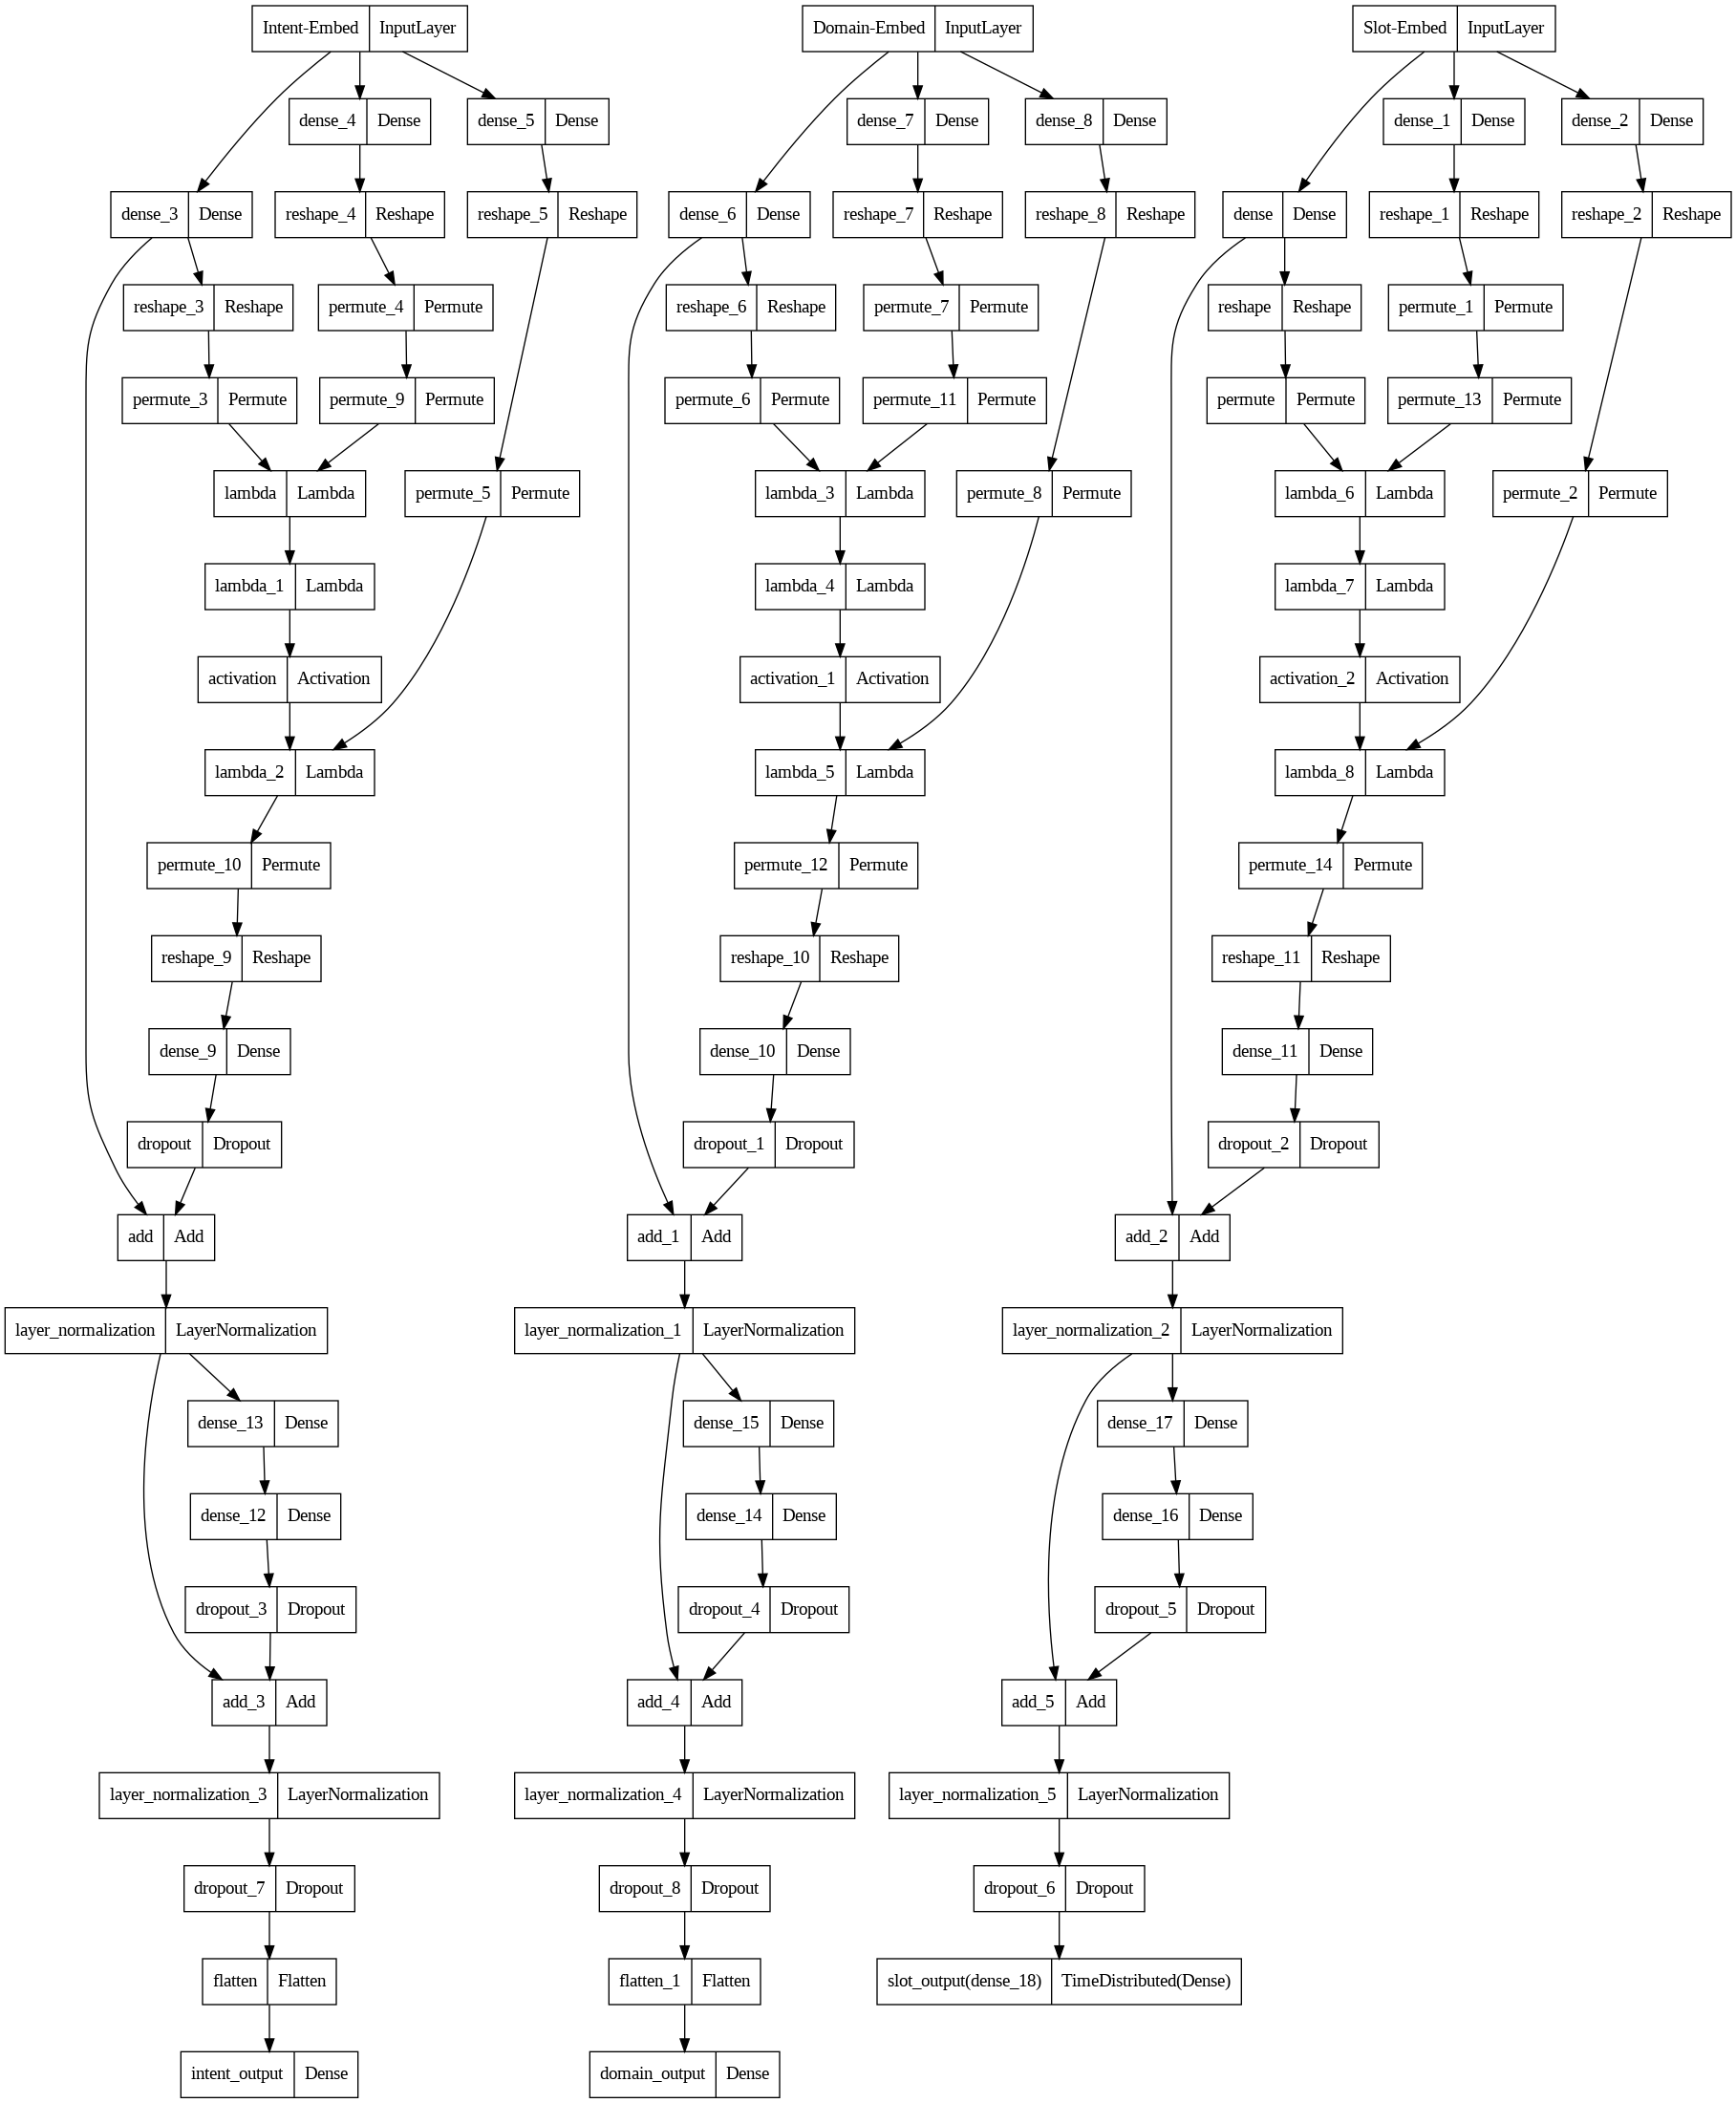

In [34]:
trans_model=get_model_by_encoder_num('noex',1)
tf.keras.utils.plot_model(
trans_model,
# to_file="images/noex.png",
# show_shapes=True,
# show_layer_names=True,
# rankdir="TB",
# expand_nested=False,
# dpi=96,
)

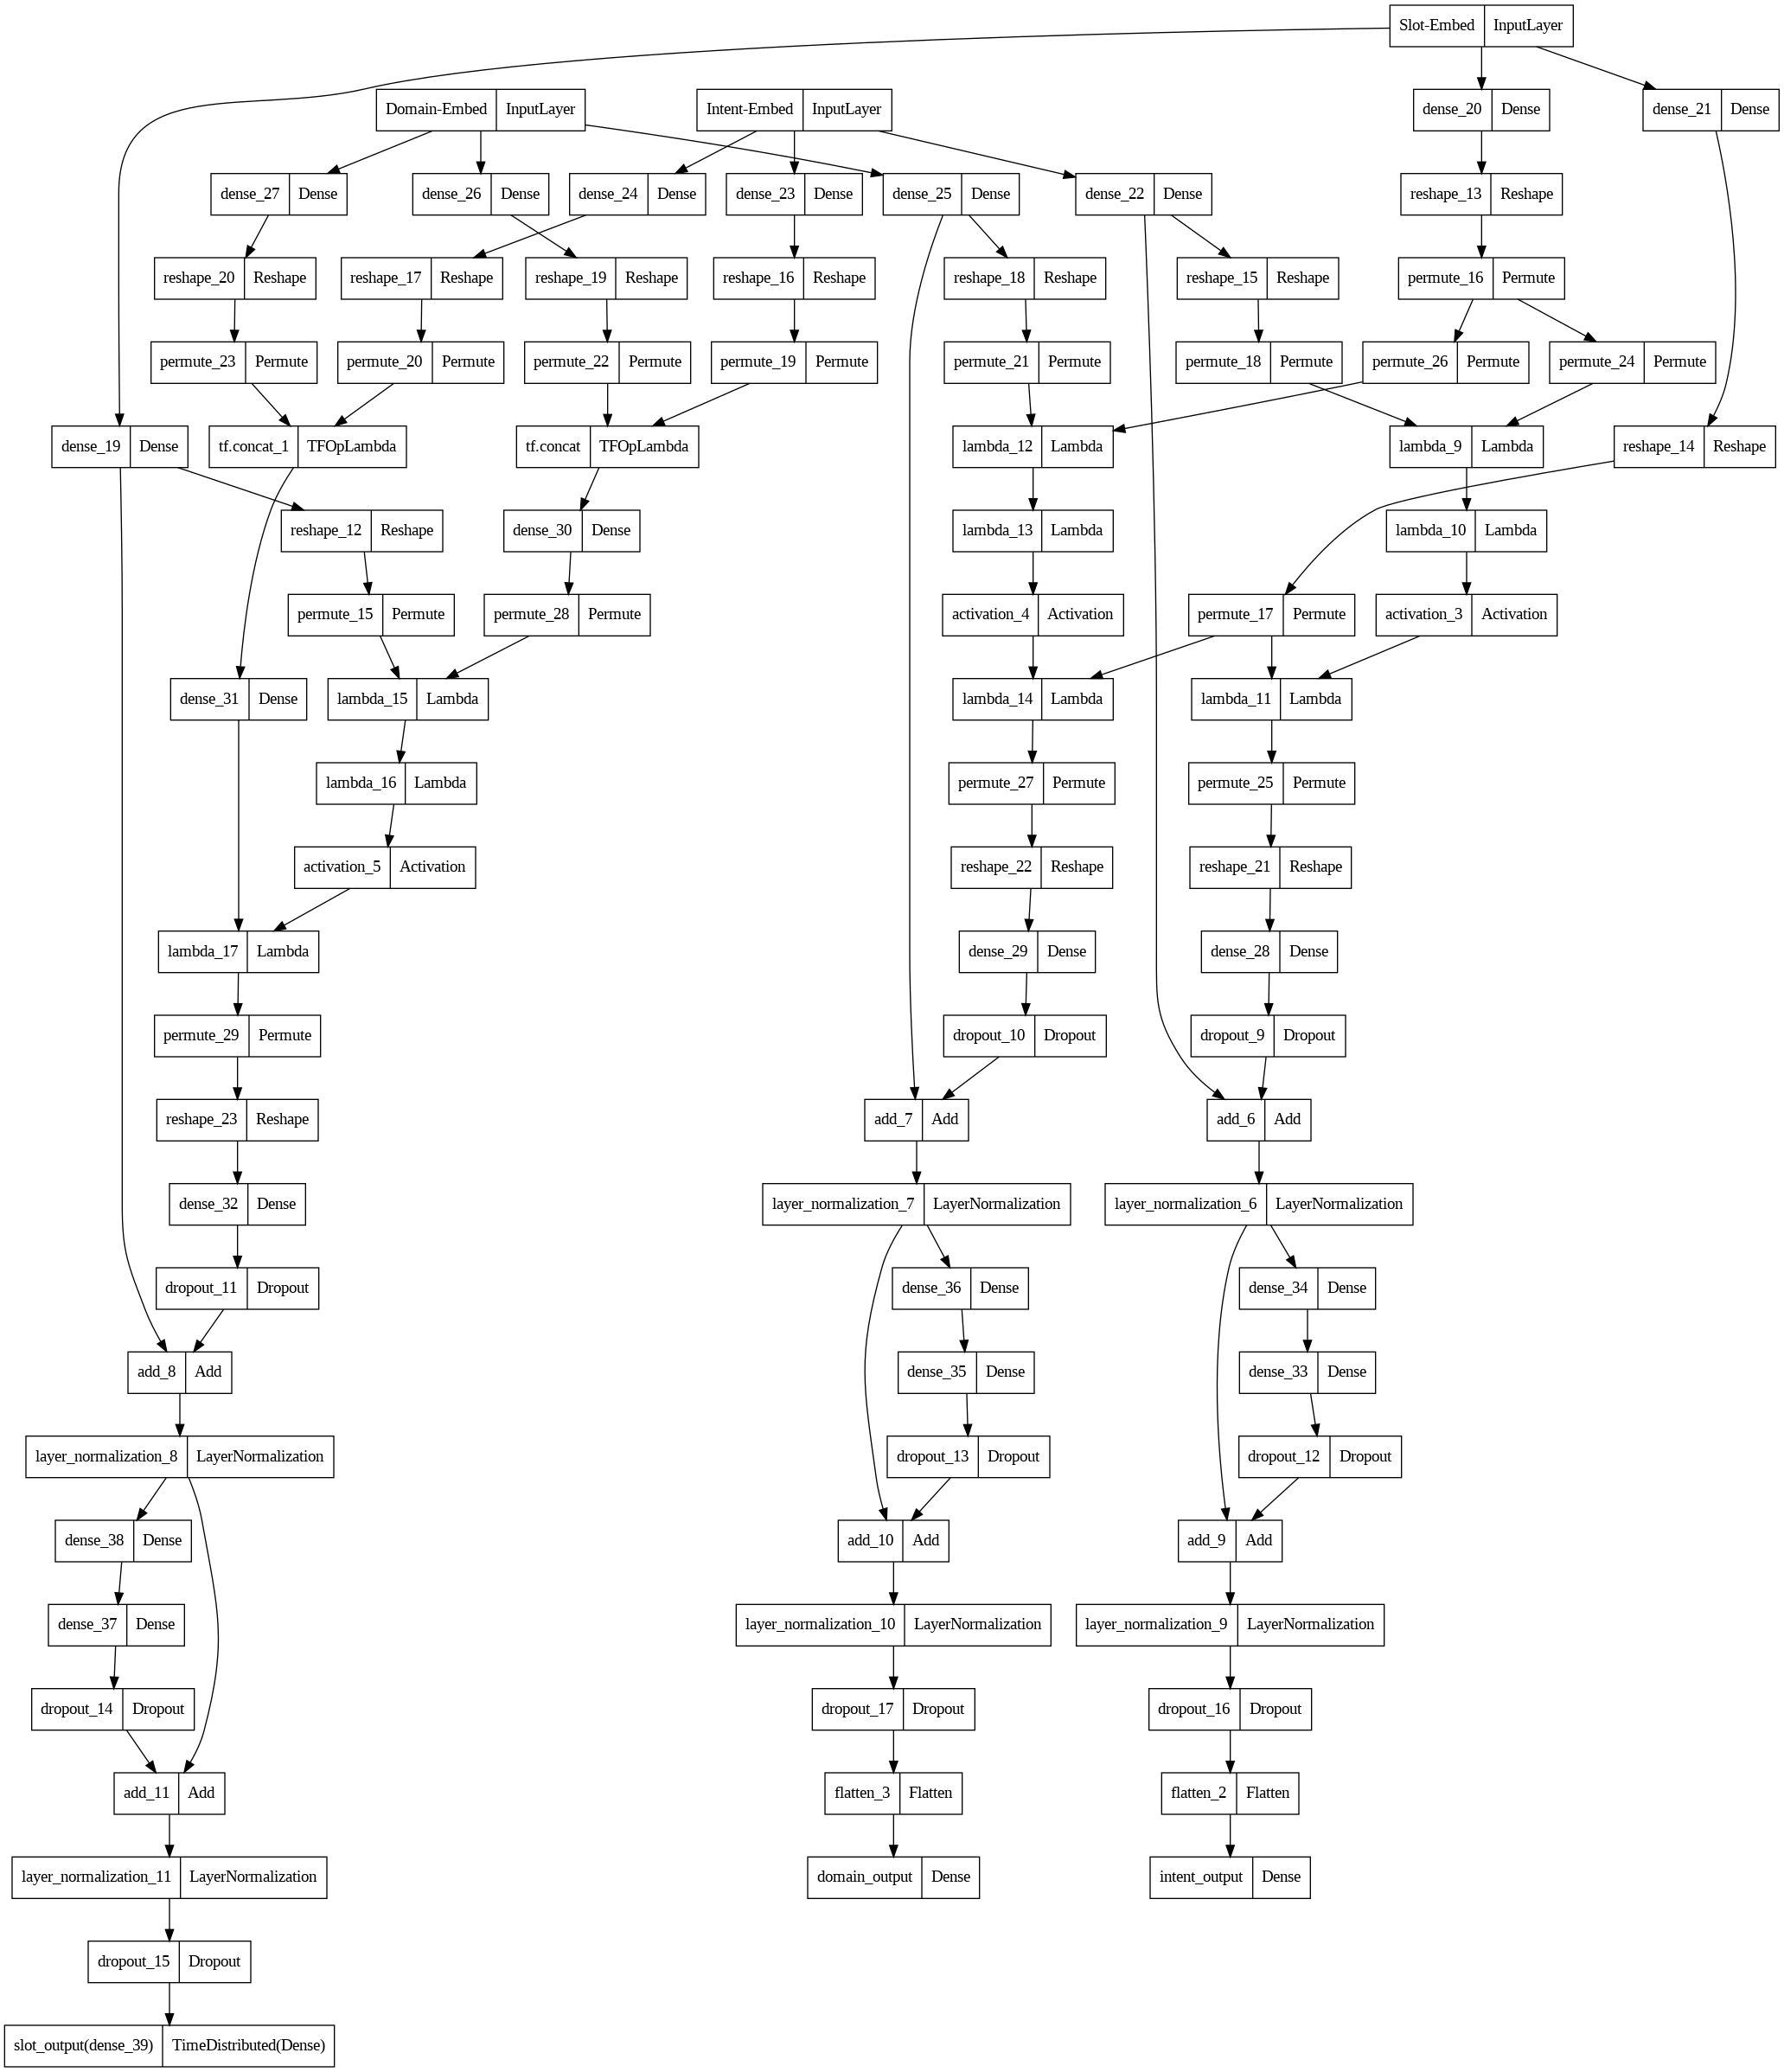

In [35]:
trans_model=get_model_by_encoder_num('cross',1)
tf.keras.utils.plot_model(
trans_model,
# to_file="images/cross.png",
# show_shapes=True,
# show_layer_names=True,
# rankdir="TB",
# expand_nested=False,
# dpi=96,
)

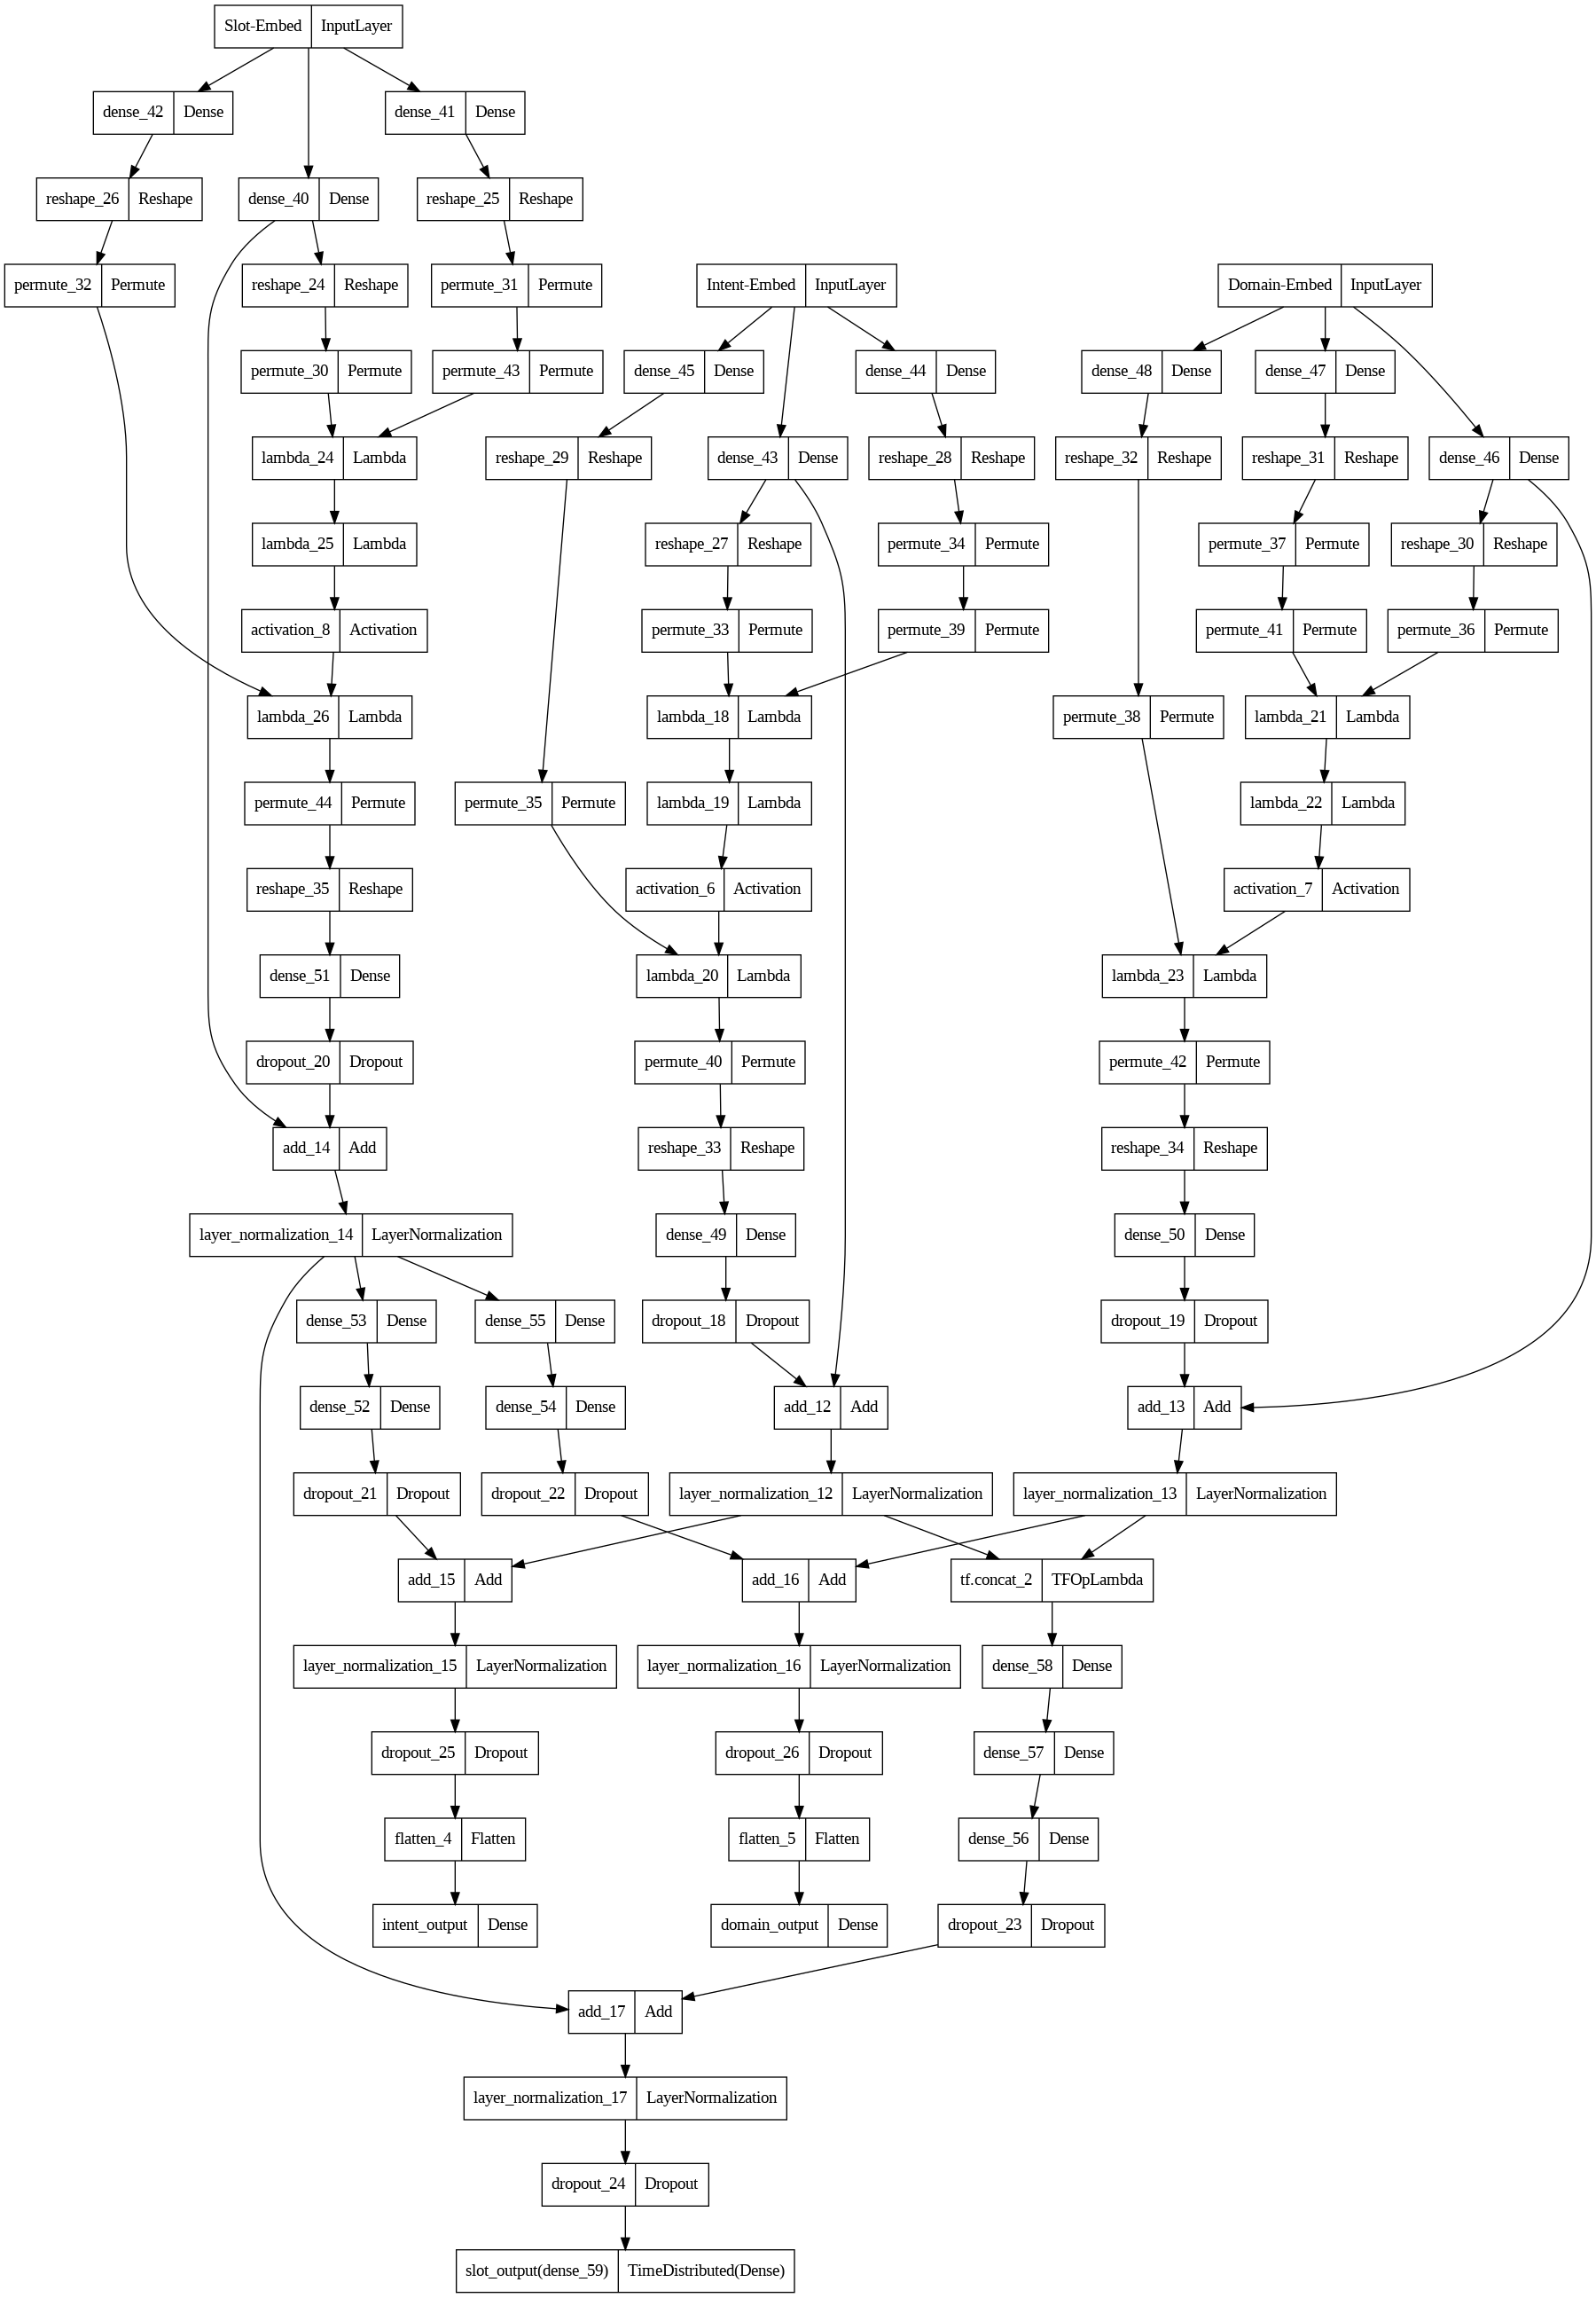

In [36]:
trans_model=get_model_by_encoder_num('bf',1)
tf.keras.utils.plot_model(
trans_model,
# to_file="images/bf.png",
# show_shapes=True,
# show_layer_names=True,
# rankdir="TB",
# expand_nested=False,
# dpi=96,
)

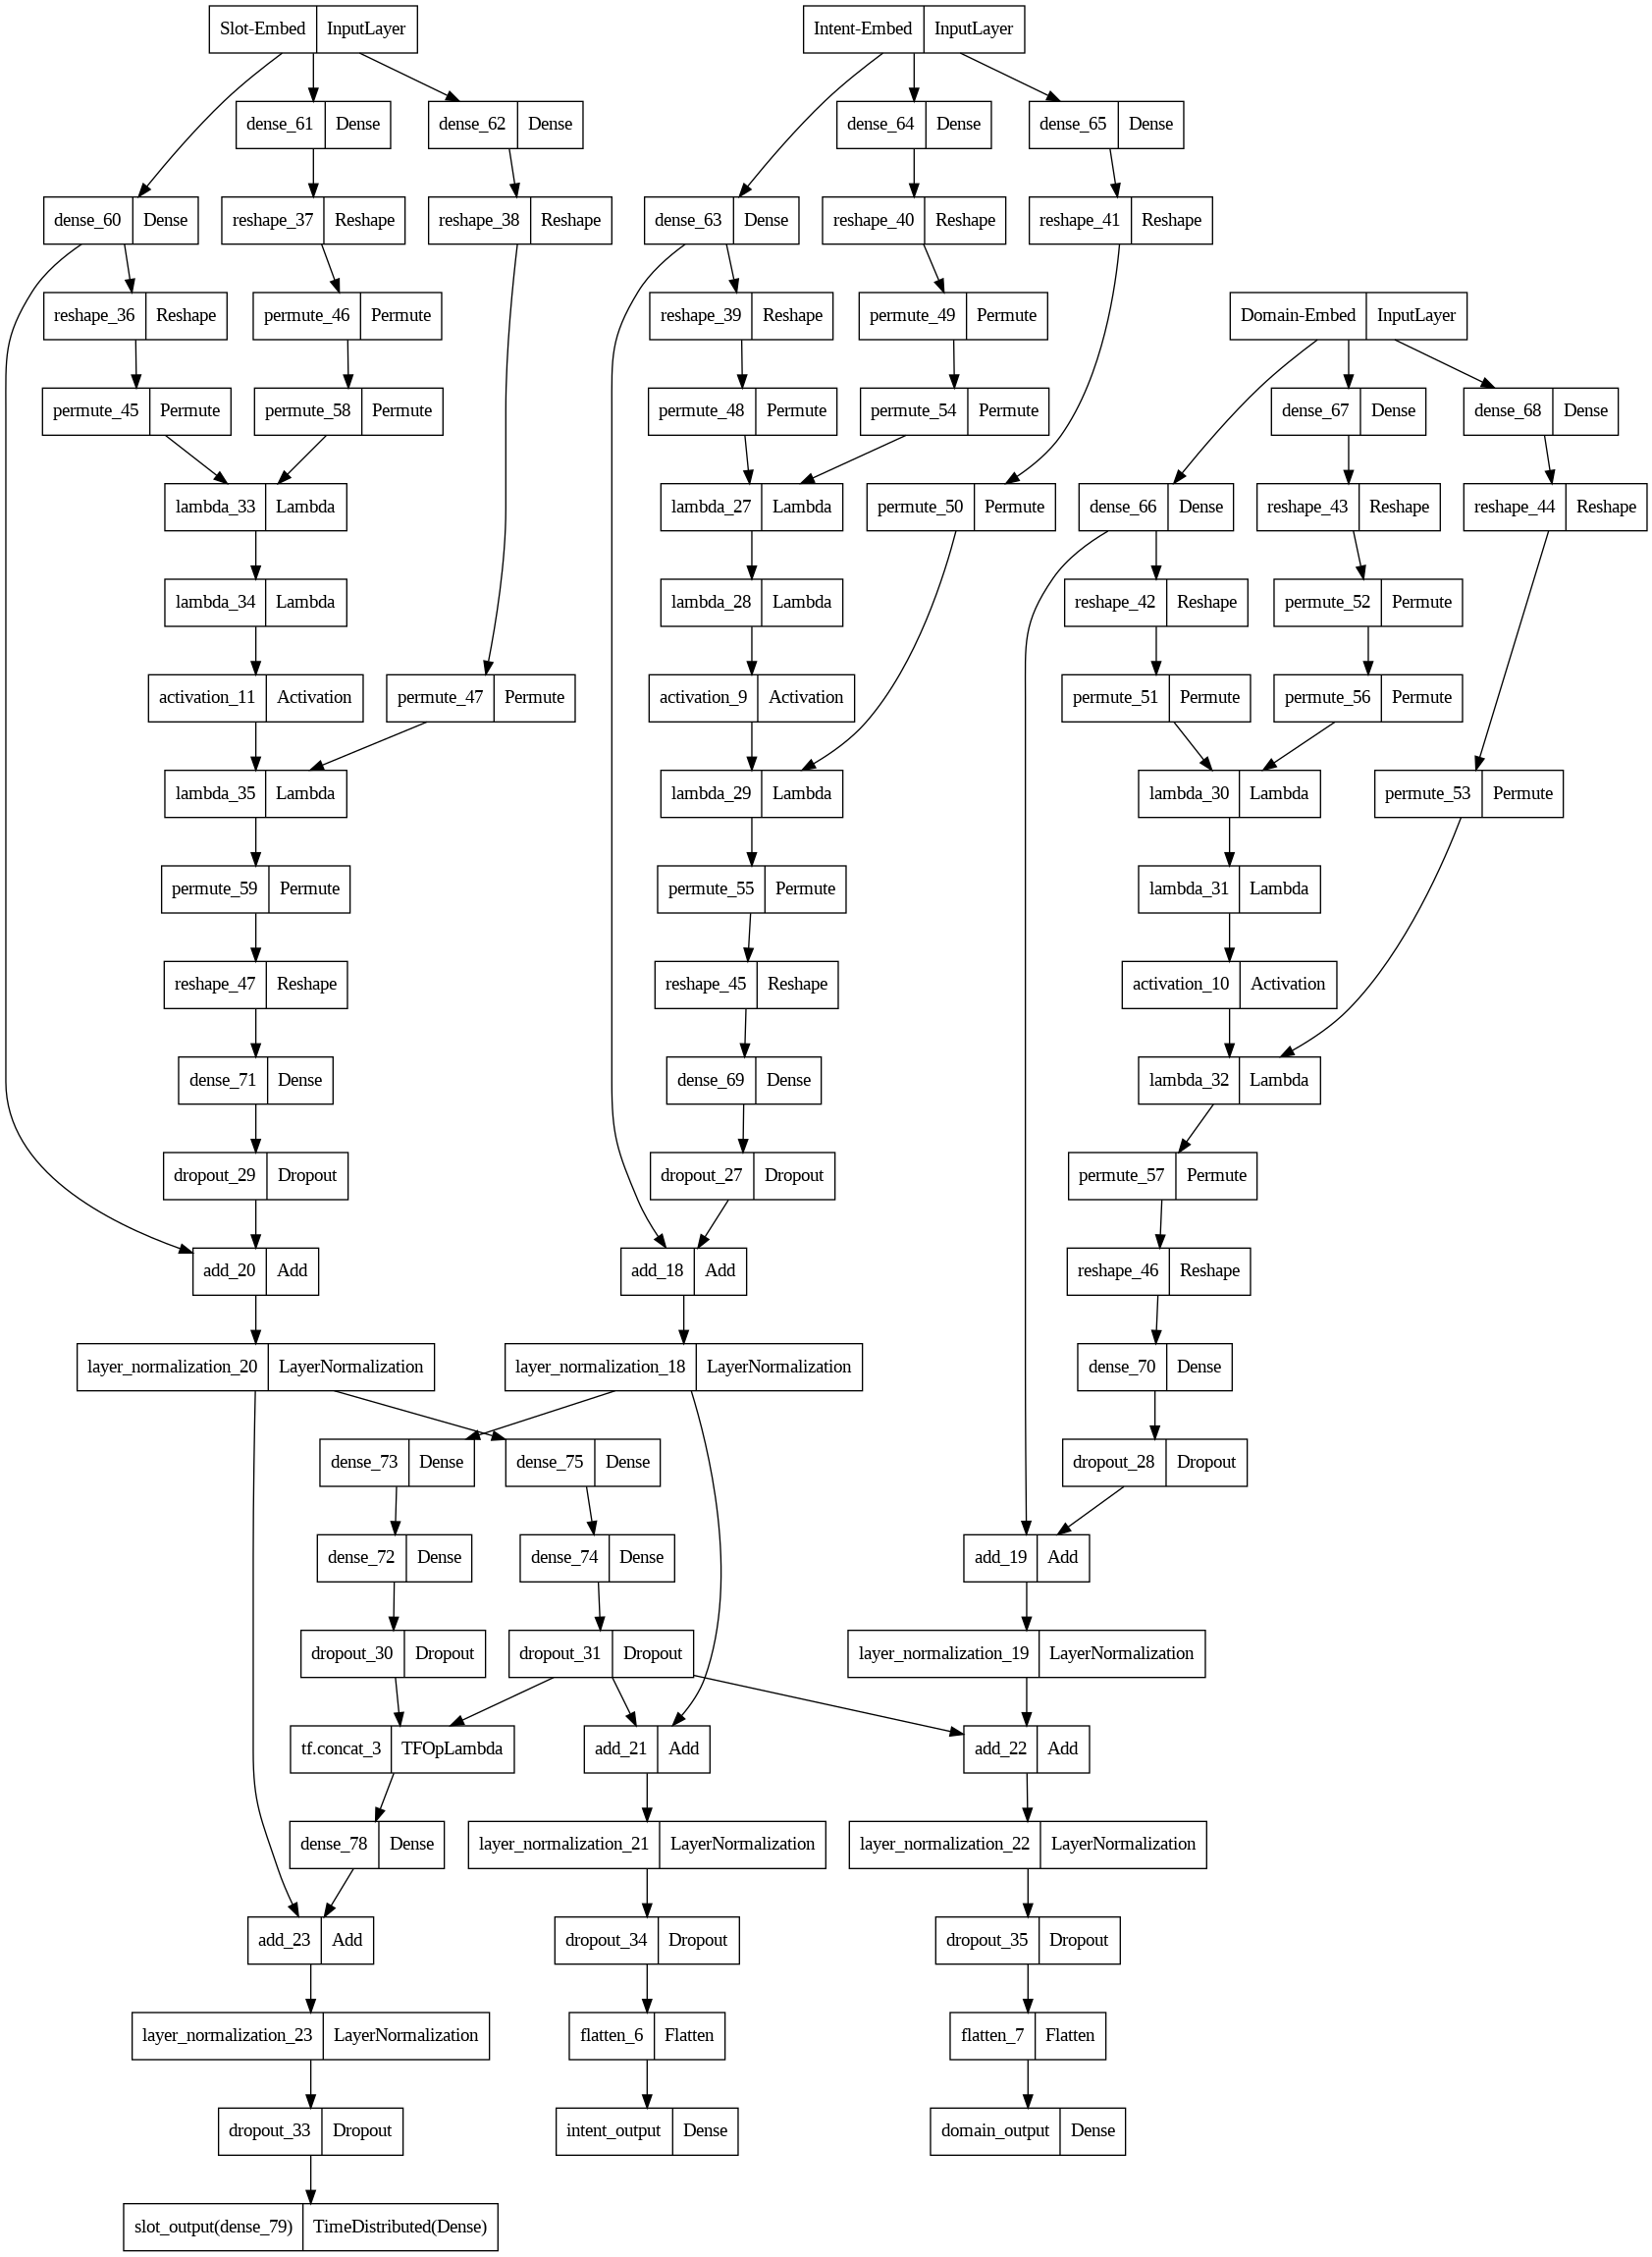

In [37]:
trans_model=get_model_by_encoder_num('af',1)
tf.keras.utils.plot_model(
trans_model,
# to_file="images/af.png",
# show_shapes=True,
# show_layer_names=True,
# rankdir="TB",
# expand_nested=False,
# dpi=96,
)

#7.Without bi-dir

## 7.1 epoch = 5, lr = 4e-4, encoder = 1

### 7.1.1 Noex

In [38]:
unique_slots = ['<PAD>'] + unique_slots

In [39]:
print(train_slot_bert.shape)
print(test_slot_bert.shape)
print(train_intent_bert.shape)
print(test_intent_bert.shape)
print(train_domain_bert.shape)
print(test_domain_bert.shape)
print(train_slot_padded.shape)
print(test_slot_padded.shape)
print(train_intent_transformed.shape)
print(test_intent_transformed.shape)
print(train_domain_transformed.shape)
print(test_domain_transformed.shape)

(13974, 18, 768)
(7998, 18, 768)
(13974, 18, 768)
(7998, 18, 768)
(13974, 18, 768)
(7998, 18, 768)
(13974, 18)
(7998, 18)
(13974,)
(7998,)
(13974,)
(7998,)


Epoch 1/5
14/14 [==============================] - 16s 98ms/step - loss: 1.6030 - slot_output_loss: 0.9165 - intent_output_loss: 0.3890 - domain_output_loss: 0.2975 - slot_output_accuracy: 0.8592 - intent_output_accuracy: 0.9042 - domain_output_accuracy: 0.8958
Epoch 2/5
14/14 [==============================] - 1s 96ms/step - loss: 0.5560 - slot_output_loss: 0.2969 - intent_output_loss: 0.0559 - domain_output_loss: 0.2032 - slot_output_accuracy: 0.9470 - intent_output_accuracy: 0.9848 - domain_output_accuracy: 0.9279
Epoch 3/5
14/14 [==============================] - 1s 97ms/step - loss: 0.4114 - slot_output_loss: 0.2081 - intent_output_loss: 0.0460 - domain_output_loss: 0.1573 - slot_output_accuracy: 0.9577 - intent_output_accuracy: 0.9853 - domain_output_accuracy: 0.9277
Epoch 4/5
14/14 [==============================] - 1s 95ms/step - loss: 0.3570 - slot_output_loss: 0.1658 - intent_output_loss: 0.0482 - domain_output_loss: 0.1430 - slot_output_accuracy: 0.9594 - intent_output_accur

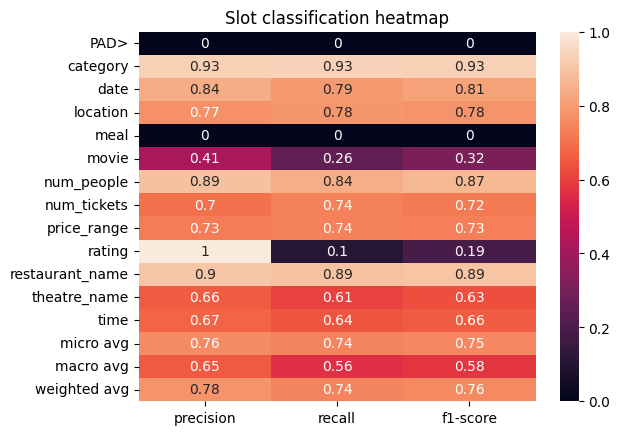

TypeError: ignored

In [40]:
#without bi-directional
epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('noex',1)
#plot_model(trans_model, to_file='images/noex.png')
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()


In [ ]:
trans_model.save('intent-slot-domain/7/7.1.1')

In [ ]:
!pip3 install ann_visualizer
!pip install graphviz

In [ ]:
%tensorboard --logdir logs/fit
# !kill 1604

In [ ]:
error throw

### 7.1.2 Cross

In [ ]:
#without bi-directional
epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('cross',1)
#plot_model(trans_model, to_file='images/cross.png')
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.1.2')

### 7.1.3 BF

In [ ]:
#without bi-directional
epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('bf',1)
plot_model(trans_model, to_file='images/bf.png')
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.1.3')

### 7.1.4 AF

In [ ]:
#without bi-directional
epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('af',1)
plot_model(trans_model, to_file='images/af.png')
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.1.4')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_names, slot_accs[-4:], 'ro')
plt.title('Slot Accuracy Comparison with #epoch=5, #Encoder=1')
plt.show()

plt.plot(model_names, intent_accs[-4:], 'go')
plt.title('Intent Accuracy Comparison with #epoch=5, #Encoder=1')
plt.show()

plt.plot(model_names, domain_accs[-4:], 'bo')
plt.title('Domain Accuracy Comparison with #epoch=5, #Encoder=1')
plt.show()

## 7.2 epoch = 10, lr = 4e-4, encoder = 1

### 7.2.1 Noex

In [ ]:
#without bi-directional
epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('noex',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.2.1')

### 7.2.2 Cross

In [ ]:
#without bi-directional
epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('cross',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
print('Intent classification heatmap')
sns.heatmap(pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T, annot=True)

In [ ]:
trans_model.save('intent-slot-domain/7/7.2.2')

### 7.2.3 BF

In [ ]:
# without bi-directional
epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('bf',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.2.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.2.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.2.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
print('Intent classification heatmap')
sns.heatmap(pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T, annot=True)

In [ ]:
trans_model.save('intent-slot-domain/7/7.2.3')

### 7.2.4 AF

In [ ]:
# without bi-directional
epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('af',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.2.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.2.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.2.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
print('Intent classification heatmap')
sns.heatmap(pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T, annot=True)

In [ ]:
trans_model.save('intent-slot-domain/7/7.2.4')

In [ ]:
plt.plot(model_names, slot_accs[-4:], 'ro')
plt.title('Slot Accuracy Comparison with #epoch=10, #Encoder=1')
plt.show()

plt.plot(model_names, intent_accs[-4:], 'go')
plt.title('Intent Accuracy Comparison with #epoch=10, #Encoder=1')
plt.show()

plt.plot(model_names, domain_accs[-4:], 'bo')
plt.title('Domain Accuracy Comparison with #epoch=10, #Encoder=1')
plt.show()

## 7.3 epoch = 15, lr = 4e-4, encoder = 1

### 7.3.1 Noex

In [ ]:
#without bi-directional
epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('noex',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.3.1')

### 7.3.2 Cross

In [ ]:
#without bi-directional
epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('cross',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.3.2')

### 7.3.3 BF

In [ ]:
#without bi-directional
epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('bf',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.3.3')

### 7.3.4 AF

In [ ]:
#without bi-directional
epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_by_encoder_num('af',1)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3].T).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.3.4')

In [ ]:
plt.plot(model_names, slot_accs[-4:], 'ro')
plt.title('Slot Accuracy Comparison with #epoch=15, #Encoder=1')
plt.show()

plt.plot(model_names, intent_accs[-4:], 'go')
plt.title('Intent Accuracy Comparison with #epoch=15, #Encoder=1')
plt.show()

plt.plot(model_names, domain_accs[-4:], 'bo')
plt.title('Domain Accuracy Comparison with #epoch=15, #Encoder=1')
plt.show()

## 7.4 epoch = 5, lr = 4e-4, encoder = 2

### 7.4.1 Noex

In [ ]:
# without bi-directional
run = 0
if run == 1:
    epoch = 5
    batch_size = 512
    learningRate = 4e-4

    trans_model=get_model_by_encoder_num('noex',2)
    train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
    evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
            np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
            np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

    test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


    evalTable = []
    print("Without bi-directional gates")
    evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
    evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

    print("="*55)
    print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
    print()

    semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
    intent_acc=intent_accuracy(test_Y_intent,preds_intent)
    domain_acc=intent_accuracy(test_Y_domain,preds_domain)
    slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

    print("Slot classification report")
    slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
    print("\nIntent classification report")
    print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
    print("\nDomain classification report")
    print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
    print()

    print("Semantic acc ", semantic_error)
    print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
    print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
    print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
    print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
    print("Intent classification accuracy ", intent_acc)
    print("Domain classification accuracy ", domain_acc)
    print()

    slot_accs.append(slot_acc)
    intent_accs.append(intent_acc)
    domain_accs.append(domain_acc)



    slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
    output_path='evaluations/7.4.1_slot_cls_report.csv'
    slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(slot_report, annot=True)
    plt.title("Slot classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
    plt.show()

    intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

    intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
    output_path='evaluations/7.4.1_intent_cls_report.csv'
    intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(intent_report, annot=True)
    plt.title("Intent classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
    plt.show()

    domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

    domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
    output_path='evaluations/7.4.1_domain_cls_report.csv'
    domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(domain_report, annot=True)
    plt.title("Domain classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (10, 10)
    sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
    plt.show()

In [ ]:
run = 0
if run == 1:
    trans_model.save('intent-slot-domain/7/7.4.1')

### 7.4.2 Cross

In [ ]:
run = 0
if run == 1:
    # without bi-directional
    epoch = 5
    batch_size = 512
    learningRate = 4e-4

    trans_model=get_model_by_encoder_num('cross',2)
    train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
    evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
            np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
            np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

    test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


    evalTable = []
    print("Without bi-directional gates")
    evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
    evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

    print("="*55)
    print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
    print()

    semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
    intent_acc=intent_accuracy(test_Y_intent,preds_intent)
    domain_acc=intent_accuracy(test_Y_domain,preds_domain)
    slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

    print("Slot classification report")
    slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
    print("\nIntent classification report")
    print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
    print("\nDomain classification report")
    print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
    print()

    print("Semantic acc ", semantic_error)
    print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
    print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
    print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
    print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
    print("Intent classification accuracy ", intent_acc)
    print("Domain classification accuracy ", domain_acc)
    print()

    slot_accs.append(slot_acc)
    intent_accs.append(intent_acc)
    domain_accs.append(domain_acc)



    slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
    output_path='evaluations/7.4.2_slot_cls_report.csv'
    slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(slot_report, annot=True)
    plt.title("Slot classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
    plt.show()

    intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

    intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
    output_path='evaluations/7.4.3_intent_cls_report.csv'
    intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(intent_report, annot=True)
    plt.title("Intent classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
    plt.show()

    domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

    domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
    output_path='evaluations/7.4.4_domain_cls_report.csv'
    domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(domain_report, annot=True)
    plt.title("Domain classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (10, 10)
    sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
    plt.show()

In [ ]:
run = 0
if run == 1:
    trans_model.save('intent-slot-domain/7/7.4.2')

### 7.4.3 BF

In [ ]:
# without bi-directional
run = 0
if run== 1:
    epoch = 5
    batch_size = 512
    learningRate = 4e-4

    trans_model=get_model_by_encoder_num('bf',2)
    train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
    evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
            np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
            np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

    test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


    evalTable = []
    print("Without bi-directional gates")
    evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
    evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

    print("="*55)
    print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
    print()

    semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
    intent_acc=intent_accuracy(test_Y_intent,preds_intent)
    domain_acc=intent_accuracy(test_Y_domain,preds_domain)
    slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

    print("Slot classification report")
    slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
    print("\nIntent classification report")
    print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
    print("\nDomain classification report")
    print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
    print()

    print("Semantic acc ", semantic_error)
    print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
    print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
    print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
    print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
    print("Intent classification accuracy ", intent_acc)
    print("Domain classification accuracy ", domain_acc)
    print()

    slot_accs.append(slot_acc)
    intent_accs.append(intent_acc)
    domain_accs.append(domain_acc)



    slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
    output_path='evaluations/7.4.3_slot_cls_report.csv'
    slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(slot_report, annot=True)
    plt.title("Slot classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
    plt.show()

    intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

    intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
    output_path='evaluations/7.4.3_intent_cls_report.csv'
    intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(intent_report, annot=True)
    plt.title("Intent classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
    plt.show()

    domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

    domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
    output_path='evaluations/7.4.3_domain_cls_report.csv'
    domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(domain_report, annot=True)
    plt.title("Domain classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (10, 10)
    sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
    plt.show()

In [ ]:
run = 0
if run== 1:
    trans_model.save('intent-slot-domain/7/7.4.3')

### 7.4.4 AF

In [ ]:
# without bi-directional
run = 0
if run== 1:
    epoch = 5
    batch_size = 512
    learningRate = 4e-4

    trans_model=get_model_by_encoder_num('af',2)
    train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
    evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
            np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
            np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

    test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


    evalTable = []
    print("Without bi-directional gates")
    evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
    evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

    print("="*55)
    print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
    print()

    semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
    intent_acc=intent_accuracy(test_Y_intent,preds_intent)
    domain_acc=intent_accuracy(test_Y_domain,preds_domain)
    slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

    print("Slot classification report")
    slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
    print("\nIntent classification report")
    print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
    print("\nDomain classification report")
    print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
    print()

    print("Semantic acc ", semantic_error)
    print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
    print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
    print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
    print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
    print("Intent classification accuracy ", intent_acc)
    print("Domain classification accuracy ", domain_acc)
    print()

    slot_accs.append(slot_acc)
    intent_accs.append(intent_acc)
    domain_accs.append(domain_acc)



    slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
    output_path='evaluations/7.4.4_slot_cls_report.csv'
    slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(slot_report, annot=True)
    plt.title("Slot classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
    plt.show()

    intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

    intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
    output_path='evaluations/7.4.4_intent_cls_report.csv'
    intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(intent_report, annot=True)
    plt.title("Intent classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
    plt.show()

    domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

    domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
    output_path='evaluations/7.4.4_domain_cls_report.csv'
    domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(domain_report, annot=True)
    plt.title("Domain classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (10, 10)
    sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
    plt.show()

In [ ]:
run = 0
if run== 1:
    trans_model.save('intent-slot-domain/7/7.4.4')

In [ ]:
run = 0
if run== 1:
    plt.plot(model_names, slot_accs[-4:], 'ro')
    plt.title('Slot Accuracy Comparison with #epoch=5, #Encoder=2')
    plt.show()

    plt.plot(model_names, intent_accs[-4:], 'go')
    plt.title('Intent Accuracy Comparison with #epoch=5, #Encoder=2')
    plt.show()

    plt.plot(model_names, domain_accs[-4:], 'bo')
    plt.title('Domain Accuracy Comparison with #epoch=5, #Encoder=2')
    plt.show()

## 7.5 epoch = 10, lr = 4e-4, encoder = 2

### 7.5.1 Noex

In [ ]:
# without bi-directional
run = 0
if run== 1:
    epoch = 10
    batch_size = 512
    learningRate = 4e-4

    trans_model=get_model_by_encoder_num('noex',2)
    train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
    evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
            np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
            np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

    test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


    evalTable = []
    print("Without bi-directional gates")
    evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
    evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

    print("="*55)
    print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
    print()

    semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
    intent_acc=intent_accuracy(test_Y_intent,preds_intent)
    domain_acc=intent_accuracy(test_Y_domain,preds_domain)
    slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

    print("Slot classification report")
    slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
    print("\nIntent classification report")
    print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
    print("\nDomain classification report")
    print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
    print()

    print("Semantic acc ", semantic_error)
    print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
    print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
    print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
    print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
    print("Intent classification accuracy ", intent_acc)
    print("Domain classification accuracy ", domain_acc)
    print()

    slot_accs.append(slot_acc)
    intent_accs.append(intent_acc)
    domain_accs.append(domain_acc)



    slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
    output_path='evaluations/7.5.1_slot_cls_report.csv'
    slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(slot_report, annot=True)
    plt.title("Slot classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
    plt.show()

    intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

    intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
    output_path='evaluations/7.5.1_intent_cls_report.csv'
    intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(intent_report, annot=True)
    plt.title("Intent classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (30, 20)
    sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
    plt.show()

    domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

    domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
    output_path='evaluations/7.5.1_domain_cls_report.csv'
    domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    sns.heatmap(domain_report, annot=True)
    plt.title("Domain classification heatmap")
    plt.show()
    plt.rcParams["figure.figsize"] = (10, 10)
    sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
    plt.show()


In [ ]:
# without bi-directional
run = 0
if run== 1:
    trans_model.save('intent-slot-domain/7/7.5.1')

### 7.5.2 Cross

In [ ]:
# without bi-directional
epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('cross',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)




slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.5.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.5.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.5.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.5.2')

### 7.5.3 BF

In [ ]:
3# without bi-directional
epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('bf',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)




slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.5.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.5.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.5.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.5.3')

### 7.5.4 AF

In [ ]:
# without bi-directional
epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('af',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)




slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.5.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.5.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.5.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.5.4')

In [ ]:
plt.plot(model_names, slot_accs[-4:], 'ro')
plt.title('Slot Accuracy Comparison with #epoch=10, #Encoder=2')
plt.show()

plt.plot(model_names, intent_accs[-4:], 'go')
plt.title('Intent Accuracy Comparison with #epoch=10, #Encoder=2')
plt.show()

plt.plot(model_names, domain_accs[-4:], 'bo')
plt.title('Domain Accuracy Comparison with #epoch=10, #Encoder=2')
plt.show()

## 7.6 epoch = 15, lr = 4e-4, encoder = 2

### 7.6.1 Noex

In [ ]:
# without bi-directional
epoch = 20
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('noex',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)




slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.6.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.6.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.6.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.6.1')

### 7.6.2 Cross

In [ ]:
# without bi-directional
epoch = 20
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('cross',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.6.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.6.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.6.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.6.2')

### 7.6.3 BF

In [ ]:
# without bi-directional
epoch = 20
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('bf',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.6.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.6.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.6.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.6.3')

### 7.6.4 AF

In [ ]:
# without bi-directional
epoch = 20
batch_size = 512
learningRate = 4e-4

trans_model=get_model_by_encoder_num('af',2)
train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("Without bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/7.6.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/7.6.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/7.6.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/7/7.6.4')

In [ ]:
plt.plot(model_names, slot_accs[-4:], 'ro')
plt.title('Slot Accuracy Comparison with #epoch=15, #Encoder=2')
plt.show()

plt.plot(model_names, intent_accs[-4:], 'go')
plt.title('Intent Accuracy Comparison with #epoch=15, #Encoder=2')
plt.show()

plt.plot(model_names, domain_accs[-4:], 'bo')
plt.title('Domain Accuracy Comparison with #epoch=15, #Encoder=2')
plt.show()

In [ ]:
all_model_names = [name+'+#epoch=5+#Encoder=1' for name in model_names] + [name+'+#epoch=10+#Encoder=1' for name in model_names] + [name+'+#epoch=15+#Encoder=1' for name in model_names] +\
                  [name+'+#epoch=5+#Encoder=2' for name in model_names] + [name+'+#epoch=10+#Encoder=2' for name in model_names] + [name+'+#epoch=15+#Encoder=2' for name in model_names]

#8.With bi-dir

## 8.1 epoch = 5, lr = 4e-4, encoder = 1

### 8.1.1 Noex

In [ ]:
# with bi-directional

epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('noex',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.1.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.1.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.1.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.1.1')

### 8.1.2 Cross

In [ ]:
# with bi-directional

epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('cross',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.1.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.1.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.1.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.1.2')

### 8.1.3 BF

In [ ]:
# with bi-directional

epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('bf',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.1.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.1.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.1.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.1.3')

### 8.1.4 AF

In [ ]:
# with bi-directional

epoch = 5
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('af',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.1.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.1.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.1.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.1.4')

## 8.2 epoch = 10, lr = 4e-4, encoder = 1

### 8.2.1 Noex

In [ ]:
# with bi-directional

epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('noex',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.2.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.2.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.2.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.2.1')

### 8.2.2 Cross

In [ ]:
# with bi-directional

epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('cross',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.2.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.2.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.2.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.2.2')

### 8.2.3 BF

In [ ]:
# with bi-directional

epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('bf',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.2.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.2.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.2.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.2.3')

### 8.2.4 AF

In [ ]:
# with bi-directional

epoch = 10
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('af',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.2.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.2.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.2.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.2.4')

## 8.3 epoch = 15, lr = 4e-4, encoder = 1

### 8.3.1 Noex

In [ ]:
# with bi-directional

epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('noex',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.3.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.3.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.3.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.3.1')

### 8.3.2 Cross

In [ ]:
# with bi-directional

epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('cross',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.3.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.3.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.3.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.3.2')

### 8.3.3 BF

In [ ]:
# with bi-directional

epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('bf',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.3.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.3.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.3.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.3.3')

### 8.3.4 AF

In [ ]:
# with bi-directional

epoch = 15
batch_size = 1024
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('af',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.3.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.3.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.3.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.3.4')

## 8.4 epoch = 5, lr = 4e-4, encoder = 2

### 8.4.1 Noex

In [ ]:
# with bi-directional

epoch = 5
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('noex',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.4.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.4.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.4.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.4.1')

### 8.4.2 Cross

In [ ]:
# with bi-directional

epoch = 5
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('cross',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.4.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.4.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.4.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.4.2')

### 8.4.3 BF

In [ ]:
# with bi-directional

batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('bf',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.4.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.4.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.4.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.4.3')

### 8.4.4 AF

In [ ]:
# with bi-directional

epoch = 5
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('af',1)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.4.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.4.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.4.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.4.4')

## 8.5 epoch = 10, lr = 4e-4, encoder = 2

### 8.5.1 Noex

In [ ]:
# with bi-directional

epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('noex',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.5.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.5.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.5.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.5.1')

### 8.5.2 Cross

In [ ]:
# with bi-directional

epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('cross',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.5.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.5.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.5.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.5.2')

### 8.5.3 BF

In [ ]:
# with bi-directional

epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('bf',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.5.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.5.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.5.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.5.3')

### 8.5.4 AF

In [ ]:
# with bi-directional

epoch = 10
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('af',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)


slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.5.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.5.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.5.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.5.4')

## 8.6 epoch = 15, lr = 4e-4, encoder = 2

### 8.6.1 Noex

In [ ]:
# with bi-directional

epoch = 20  # HW changed from 15
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('noex',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.6.1_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.6.1_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.6.1_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.6.1')

### 8.6.2 Cross

In [ ]:
2# with bi-directional


epoch = 20  # HW changed from 15
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('cross',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.6.2_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.6.2_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.6.2_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.6.2')

### 8.6.3 BF

In [ ]:
# with bi-directional


epoch = 20  # HW changed from 15
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('bf',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.6.3_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.6.3_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.6.3_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.6.4')

### 8.6.4 AF

In [ ]:
# with bi-directional

epoch = 15
batch_size = 512
learningRate = 4e-4

trans_model=get_model_bidir_by_encoder_num('af',2)

train_acc, eval_acc, train_time, eval_time, test_Y_slot, test_Y_intent, test_Y_domain, preds_slot, preds_intent, preds_domain = \
evaluate(trans_model, train_slot_bert, test_slot_bert, train_intent_bert, test_intent_bert, train_domain_bert, test_domain_bert, \
         np.expand_dims(train_slot_padded, -1), np.expand_dims(test_slot_padded, -1), np.array(train_intent_transformed), np.array(test_intent_transformed),  \
         np.array(train_domain_transformed), np.array(test_domain_transformed), batch_size, epoch, learningRate)

test_Y_slot = np.squeeze(test_Y_slot, axis=-1)


evalTable = []
print("With bi-directional gates")
evalTable.append(["Training", np.mean(train_acc), np.mean(train_time)])
evalTable.append(["Evaluation", np.mean(eval_acc), np.mean(eval_time)])

print("="*55)
print(tabulate(evalTable, headers = ["Accuracy", "Evaluation Time"]))
print()

semantic_error=sentence_senm(test_Y_intent, preds_intent, test_Y_slot, preds_slot, test_Y_domain, preds_domain)
intent_acc=intent_accuracy(test_Y_intent,preds_intent)
domain_acc=intent_accuracy(test_Y_domain,preds_domain)
slot_acc_ind, precision_ind, recall_ind, f1_ind= slot_accuracy(test_Y_slot, preds_slot)

print("Slot classification report")
slot_report, slot_acc, precision, recall, f1= slot_accuracy_slot_based(test_Y_slot.tolist(), preds_slot.tolist())
print("\nIntent classification report")
print(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()]))
print("\nDomain classification report")
print(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()]))
print()

print("Semantic acc ", semantic_error)
print("Slot filling accuracy (slot-based)", slot_acc, " (individual-based)", slot_acc_ind)
print("Slot filling precision (slot-based)", precision, " (individual-based)", precision_ind)
print("Slot filling recall (slot-based)", recall, " (individual-based)", recall_ind)
print("Slot filling F1 score (slot-based)", f1, " (individual-based)", f1_ind)
print("Intent classification accuracy ", intent_acc)
print("Domain classification accuracy ", domain_acc)
print()

slot_accs.append(slot_acc)
intent_accs.append(intent_acc)
domain_accs.append(domain_acc)



slot_report.style.set_table_attributes("style='display:inline'").set_caption('slot_report')
output_path='evaluations/8.6.4_slot_cls_report.csv'
slot_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(slot_report, annot=True)
plt.title("Slot classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot(unique_slots, slot_report['f1-score'][:-3]).set(title='Slot Classification Report')
plt.show()

intent_report = pd.DataFrame(classification_report([ind2intent[x] for x in test_Y_intent.tolist()],[ind2intent[x] for x in preds_intent.tolist()],output_dict=True)).iloc[:-1, :].T

intent_report.style.set_table_attributes("style='display:inline'").set_caption('intent_report')
output_path='evaluations/8.6.4_intent_cls_report.csv'
intent_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(intent_report, annot=True)
plt.title("Intent classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (30, 20)
sns.barplot( unique_intents, intent_report['f1-score'][:-3]).set(title='Intent Classification Report')
plt.show()

domain_report = pd.DataFrame(classification_report([ind2domain[x] for x in test_Y_domain.tolist()],[ind2domain[x] for x in preds_domain.tolist()],output_dict=True)).iloc[:-1, :].T

domain_report.style.set_table_attributes("style='display:inline'").set_caption('domain_report')
output_path='evaluations/8.6.4_domain_cls_report.csv'
domain_report.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
sns.heatmap(domain_report, annot=True)
plt.title("Domain classification heatmap")
plt.show()
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(unique_domains, domain_report['f1-score'][:-3]).set(title='Domain Classification Report')
plt.show()

In [ ]:
trans_model.save('intent-slot-domain/8/8.6.4')